# Exploratory Data Analysis (EDA) - density pixels of NYC map 
---
Clustering algorithm for NYC map by summed-trips density (trips/area). Quantizing pickup/dropoff coordinate to density values, instead of labels from general clustering. The algorithm doesn't just keep less dimensions but give physical meaning of the pickup/dropoff zones, where the trip should belonged to. By standardized the density, it can represent the trip from/to the higher/lower using-frequencies zone. By the powerful Numpy, the algorithm performs quite fast and straght forward. 

* **Overview default data**
<br />Use [train.csv](../data/train.csv) to do analysis, containing $1\,458\,644$ trips.

| Name | Description | type | unit |
| :----: | :---- | :----: | :----: | 
| id | a unique identifier for each trip | object |  |
| vendor_id | a code indicating the provider associated with the trip record | int | |
| pickup_datetime | date and time when the meter was engaged | object | |
| dropoff_datetime | date and time when the meter was disengaged (not in test data)| object | |
| passenger_count | the number of passengers in the vehicle (driver entered value) | int | people |
| pickup_longitude | the longitude where the meter was engaged | float | degree |
| pickup_latitude | the latitude where the meter was engaged | float | degree |
| dropoff_longitude | the longitude where the meter was disengaged | float | degree | 
| dropoff_latitude | the latitude where the meter was disengaged | float | degree |
| store_and_fwd_flag | This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip | object | |
| trip_duration | duration of the trip | int | second |

---
## Import modules & function defination

In [1]:
import re, calendar, time, datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import string

In [2]:
def select_region( df_in, df_ref, name='pickup', zoom=1. ):
    cutmap = zoom/100.
    return df_in[ (df_ref[name+'_longitude'] < df_ref[name+'_longitude'].quantile(1-cutmap)) & 
                  (df_ref[name+'_longitude'] > df_ref[name+'_longitude'].quantile(cutmap))   & 
                  (df_ref[name+'_latitude']  < df_ref[name+'_latitude'].quantile(1-cutmap))  &  
                  (df_ref[name+'_latitude']  > df_ref[name+'_latitude'].quantile(cutmap))  ]

def get_haversine_distance(lng1, lat1, lng2, lat2):
    # km
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  #  km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h 

In [3]:
def make_hist( X, xmax=None, xmin=None, binw=1, scale=1., xlabel='Input', ylabel='Counts', xunit='', edgecolor='black', tightLabel=False, centerLabel=False, debug=False, log=False, **hist_kwds ):    
    if not xmax:
        xmax = max(X)+binw
    if not xmin:
        xmin = min(X) if (min(X) < 0) or (min(X) >=1) else 0 
        
    if xmax <= xmin: 
        xmax = max(X)+binw
        xmin = min(X) if (min(X) < 0) or (min(X) >=1) else 0 

    x = X[ (X <= xmax) & (X >= xmin) ]
    weights = np.repeat(scale, len(x))
    hist_info_ = plt.hist( 
                           x = x,
                           bins = np.arange(xmin, xmax+binw, binw), # Due to end 2 bins are 1, hist will combined them to a bin. 
                           edgecolor = edgecolor,
                           log=log,
                           weights=weights,
                           **hist_kwds
                         )
    if scale != 1.:
        ylabel = ylabel+' x %.1f'%(1/scale)
    if xunit == '': 
        ylabel = ylabel+' / %.2f'%(binw)
    else:
        xlabel = xlabel+' [%s]'%(xunit)
        ylabel = ylabel+' / %.2f %s'%(binw, xunit)
    plt.tick_params(labelsize=20)
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)
    plt.ylim(ymin = 0.5 if log else 0)
    
    # Show label be bin by bin
    if tightLabel: 
        plt.xticks(hist_info_[1])
    
    # Make label be in bins' center
    if tightLabel and centerLabel:
        ax_min = min(hist_info_[1])
        ax_max = max(hist_info_[1])
        ax_wth = (hist_info_[1][1]-hist_info_[1][0])/2.
        newrange = np.arange(ax_min, ax_max+ax_wth, ax_wth)
        newnames, n = [], 0
        for i in range(len(newrange)):
            if i%2 == 0: 
                newnames.append('')
            elif n < len(hist_info_[1]): 
                v = hist_info_[1][n] if hist_info_[1][n]%1 != 0 else int(hist_info_[1][n])
                newnames.append(v)
                n+=1   
        plt.xticks(newrange, newnames)
        if debug: print ax_min, ax_max, ax_wth, newrange

    return hist_info_

In [76]:
def make_hist2d( x, y, xbinw=1, ybinw=1, xlabel='', ylabel='', xmargin=0, ymargin=0, cmap='hot', alpha=0.85, title='', debug=False, **hist2d_kwds):
    xmin, xmax, ymin, ymax = min(x), max(x), min(y), max(y)
    rangex, rangey = [ xmin-xmargin, xmax+xmargin ], [ymin-ymargin, ymax+ymargin]
    #print rangex, rangey
    bins = [ int((rangex[1]-rangex[0])/xbinw), int((rangey[1]-rangey[0])/ybinw) ]
    counts, xedges, yedges, image = plt.hist2d( x=x, 
                                                y=y,  
                                                range=[rangex, rangey],
                                                bins=bins, 
                                                cmap=cmap, 
                                                alpha=alpha, 
                                                **hist2d_kwds)
    plt.colorbar(image)
    plt.tick_params(labelsize=20)
    plt.title(title, fontsize=25)
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)
    plt.grid(False)
    
    if debug:
        print 'Total  : %d counts'% np.sum(counts)
        print '%d zones has non-zero density'% len(counts[ counts != 0 ])
        print 'Highest density :',np.max(counts)
    
    # counts - dims (2d) = xbins (row) X ybins (culomn)
    # xedges - dims (1d) = xbins + 1
    # yedges - dims (1d) = ybins + 1
    data = { 'counts' : counts.ravel().astype(int),
             'x1' : np.repeat(xedges[:-1],  len(yedges)-1),
             'x2' : np.repeat(xedges[1:],   len(yedges)-1),
             'y1' : np.tile(yedges[:-1],    len(xedges)-1),
             'y2' : np.tile(yedges[1:],     len(xedges)-1) }

    return pd.DataFrame(data=data)

---
## 1. Load data & extract variables
### 1.1. Load train data

In [5]:
#df = pd.read_csv('../data/train.csv')
#df = pd.read_csv('../data/train_timefixed.csv')
df = pd.read_csv('../data/train_eda.csv')
df.head(2)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_day,pickup_time,pickup_weekday,pickup_timestamp,dropoff_month,dropoff_day,dropoff_time,dropoff_weekday,dropoff_timestamp,store_and_fwd_flag,distance
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,3,14,17.415278,1,1457947495,3,14,17.541667,1,1457947950,0,1.498521
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,6,12,0.726389,7,1465663415,6,12,0.910556,7,1465664078,0,1.805507


In [6]:
x_pick, x_drop = df['pickup_longitude'], df['dropoff_longitude']
y_pick, y_drop = df['pickup_latitude'],  df['dropoff_latitude']
df_lon = pd.Series(np.hstack((x_pick.values, x_drop.values)))
df_lat = pd.Series(np.hstack((y_pick.values, y_drop.values)))

---
## 2. Density study
### 2.1. Counting trips

In [7]:
xmax = df_lon.quantile(0.9995)
xmin = df_lon.quantile(0.0005)
ymax = df_lat.quantile(0.9995)
ymin = df_lat.quantile(0.0005)
print xmax, xmin, 
print ymax, ymin

-73.7340518455 -74.1777572632 40.8929241676 40.6016387939


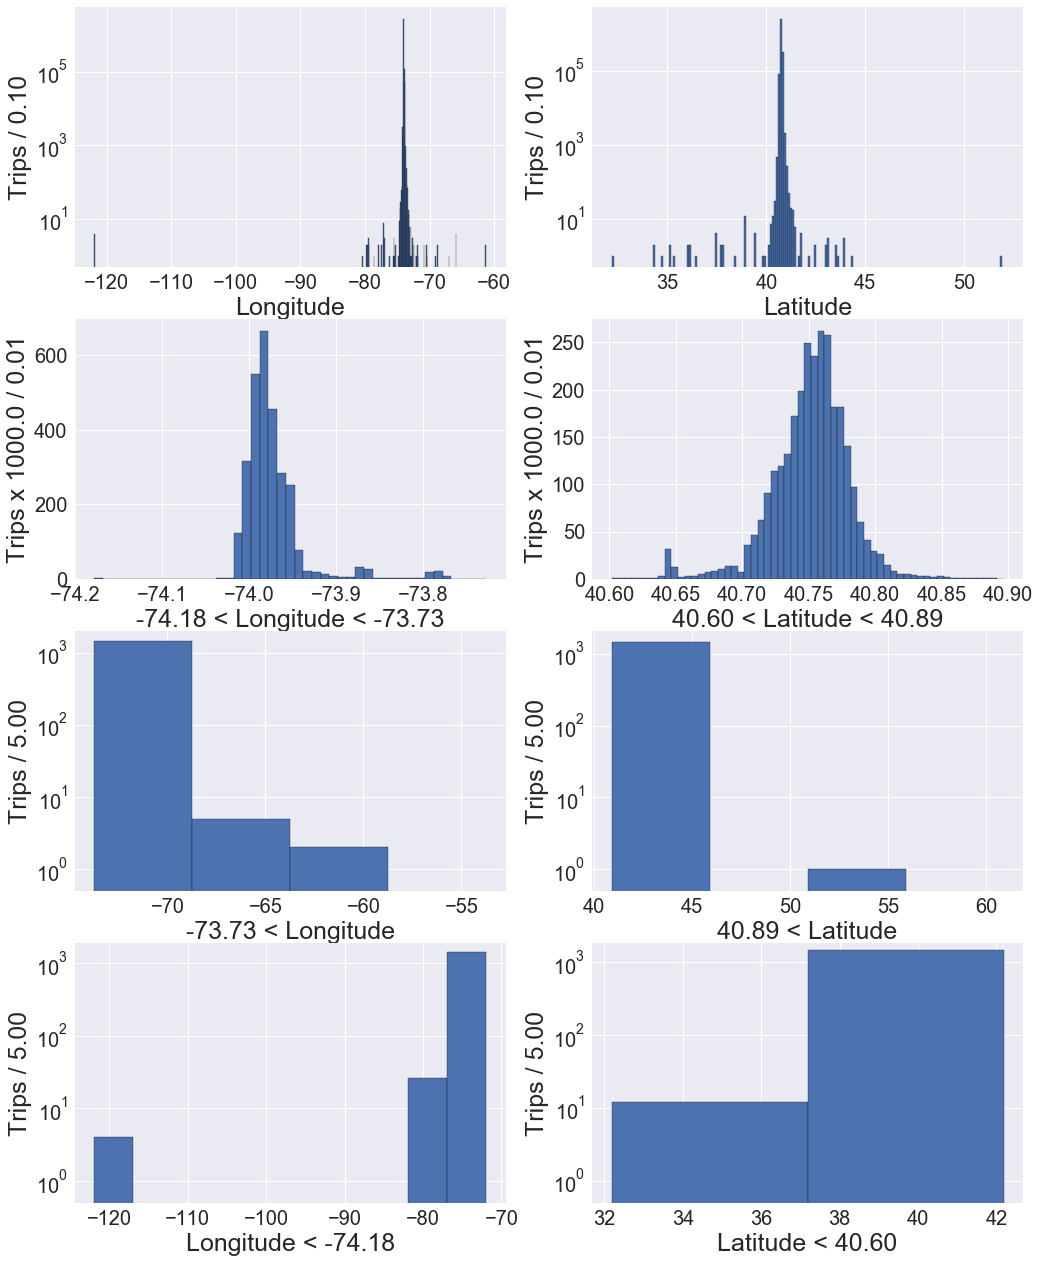

In [8]:
fig = plt.figure(figsize=(17,22))
fig.add_subplot(4,2,1)
make_hist(df_lon, binw=0.1, xlabel='Longitude', ylabel='Trips', log=True)
fig.add_subplot(4,2,2)
make_hist(df_lat, binw=0.1, xlabel='Latitude', ylabel='Trips', log=True)
fig.add_subplot(4,2,3)
make_hist(df_lon, xmax=xmax, xmin=xmin, binw=0.01, xlabel='%.2f < Longitude < %.2f'%(xmin, xmax), ylabel='Trips', scale=0.001)
fig.add_subplot(4,2,4)
make_hist(df_lat, xmax=ymax, xmin=ymin, binw=0.005, xlabel='%.2f < Latitude < %.2f'%(ymin, ymax), ylabel='Trips', scale=0.001)
fig.add_subplot(4,2,5)
make_hist(df_lon, xmin=xmax, binw=5, xlabel='%.2f < Longitude'%(xmax), ylabel='Trips', log=True)
fig.add_subplot(4,2,6)
make_hist(df_lat, xmin=ymax, binw=5, xlabel='%.2f < Latitude'%(ymax), ylabel='Trips', log=True)
fig.add_subplot(4,2,7)
make_hist(df_lon, xmax=xmin, binw=5, xlabel='Longitude < %.2f'%(xmin), ylabel='Trips', log=True)
fig.add_subplot(4,2,8)
make_hist(df_lat, xmax=ymin, binw=5, xlabel='Latitude < %.2f'%(ymin), ylabel='Trips', log=True)
plt.show()

## 2.2. Width decision

In [9]:
def makeNonunitBins( x, bmin, bmax, init=0.1, binw=0.01):
    bins = [min(x)-init]
    for b in np.arange(bmin, bmax, binw):
        bins.append(b)
    bins.append(max(x)+init)
    return bins

In [10]:
xbins = np.array(makeNonunitBins( df_lon, xmin, xmax, binw=0.005 ))
ybins = np.array(makeNonunitBins( df_lat, ymin, ymax, binw=0.005 ))
n_xbins, n_ybins = len(xbins)-1, len(ybins)-1
print 'x-size: %d, y-size: %d'%( n_xbins, n_ybins )
#pd.DataFrame(data=xbins)
print 'xbins:', xbins
print 'ybins:', ybins

x-size: 90, y-size: 60
xbins: [-122.03334198  -74.17775726  -74.17275726  -74.16775726  -74.16275726
  -74.15775726  -74.15275726  -74.14775726  -74.14275726  -74.13775726
  -74.13275726  -74.12775726  -74.12275726  -74.11775726  -74.11275726
  -74.10775726  -74.10275726  -74.09775726  -74.09275726  -74.08775726
  -74.08275726  -74.07775726  -74.07275726  -74.06775726  -74.06275726
  -74.05775726  -74.05275726  -74.04775726  -74.04275726  -74.03775726
  -74.03275726  -74.02775726  -74.02275726  -74.01775726  -74.01275726
  -74.00775726  -74.00275726  -73.99775726  -73.99275726  -73.98775726
  -73.98275726  -73.97775726  -73.97275726  -73.96775726  -73.96275726
  -73.95775726  -73.95275726  -73.94775726  -73.94275726  -73.93775726
  -73.93275726  -73.92775726  -73.92275726  -73.91775726  -73.91275726
  -73.90775726  -73.90275726  -73.89775726  -73.89275726  -73.88775726
  -73.88275726  -73.87775726  -73.87275726  -73.86775726  -73.86275726
  -73.85775726  -73.85275726  -73.84775726  -73

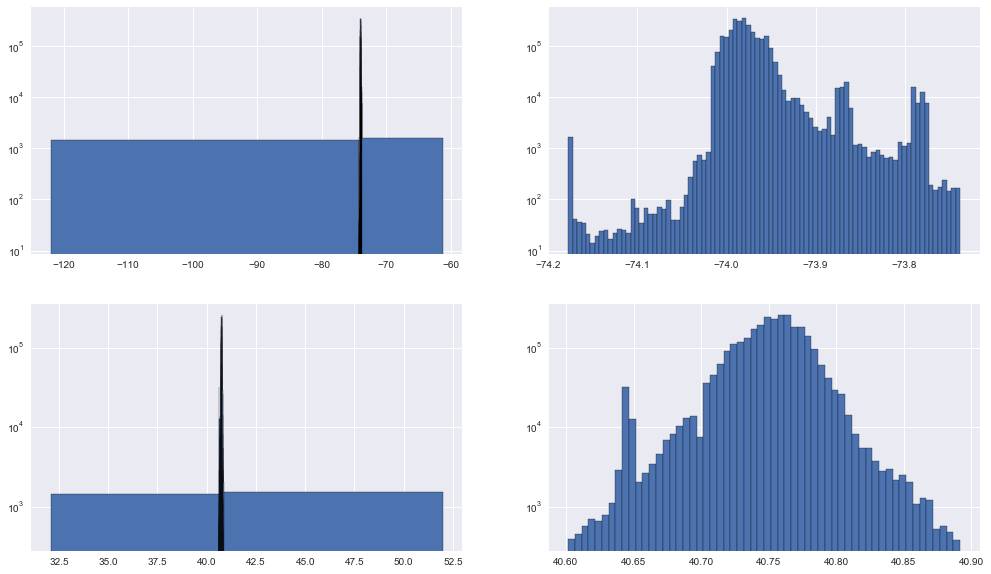

In [11]:
fig = plt.figure(figsize=(17,10))
fig.add_subplot(2,2,1)
lon_trips, lon_bins, lon_hist = plt.hist( x = df_lon, bins = xbins, edgecolor = 'black', log=True )
fig.add_subplot(2,2,2)
plt.hist( x = df_lon, bins = lon_bins[1:-1], edgecolor = 'black', log=True )
fig.add_subplot(2,2,3)
lat_trips, lat_bins, lat_hist = plt.hist( x = df_lat, bins = ybins, edgecolor = 'black', log=True )
fig.add_subplot(2,2,4)
plt.hist( x = df_lat, bins = lat_bins[1:-1], edgecolor = 'black', log=True )
plt.show()

---
## 3. Clustering
### 3.1. Real distance of width 

In [12]:
x_dist, y_dist = [], []
for i in range(n_xbins): x_dist.append(get_haversine_distance( xbins[i],       0., xbins[i+1],         0.))
for i in range(n_ybins): y_dist.append(get_haversine_distance(        0, ybins[i],         0., ybins[i+1]))
print x_dist[0], x_dist[1], x_dist[n_xbins-1] 
print y_dist[0], y_dist[1], y_dist[n_ybins-1]

5321.29823212 0.555974633223 1390.18431821
947.436138321 0.555974633223 1233.09009538


### 3.2. Labelize to longitude/latitude

In [13]:
# Labelizing
df['pick_xlabel'] = pd.DataFrame(data=np.digitize(x_pick.values, xbins))
df['pick_ylabel'] = pd.DataFrame(data=np.digitize(y_pick.values, ybins))
df['drop_xlabel'] = pd.DataFrame(data=np.digitize(x_drop.values, xbins))
df['drop_ylabel'] = pd.DataFrame(data=np.digitize(y_drop.values, ybins))
df.head(5)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_day,pickup_time,...,dropoff_day,dropoff_time,dropoff_weekday,dropoff_timestamp,store_and_fwd_flag,distance,pick_xlabel,pick_ylabel,drop_xlabel,drop_ylabel
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,3,14,17.415278,...,14,17.541667,1,1457947950,0,1.498521,41,35,44,34
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,6,12,0.726389,...,12,0.910556,7,1465664078,0,1.805507,41,29,37,27
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,19,11.590000,...,19,12.180000,2,1453176648,0,6.385098,41,34,36,23
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,4,6,19.541944,...,6,19.661111,3,1459942780,0,1.485498,35,25,35,23
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,3,26,13.515278,...,26,13.636111,6,1458970690,0,1.188588,42,40,42,38


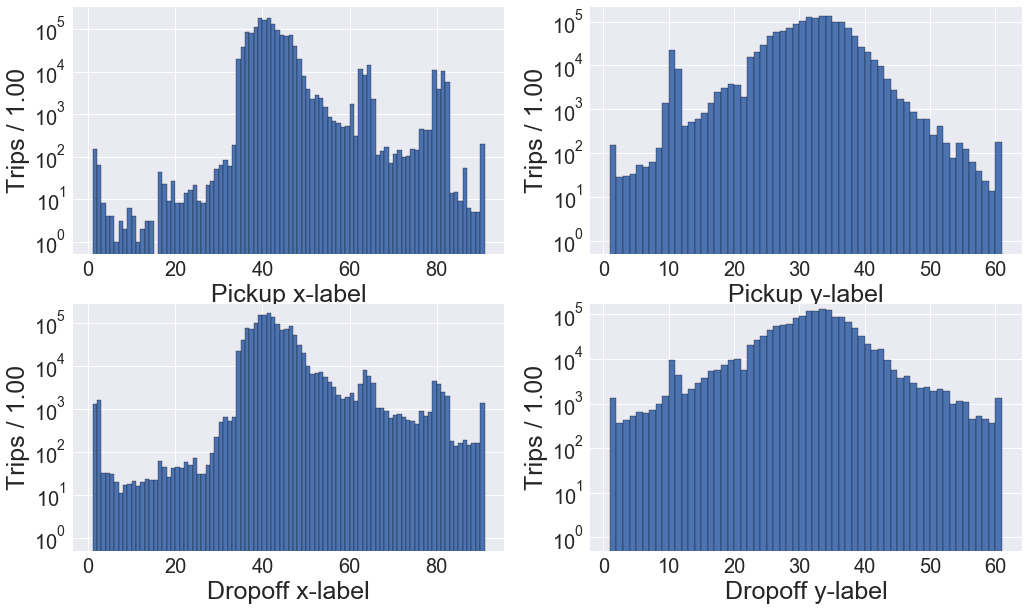

In [14]:
fig = plt.figure(figsize=(17,10))
fig.add_subplot(2,2,1)
make_hist(df['pick_xlabel'].values, binw=1, xlabel='Pickup x-label', ylabel='Trips', log=True)
fig.add_subplot(2,2,2)
make_hist(df['pick_ylabel'].values, binw=1, xlabel='Pickup y-label', ylabel='Trips', log=True)
fig.add_subplot(2,2,3)
make_hist(df['drop_xlabel'].values, binw=1, xlabel='Dropoff x-label', ylabel='Trips', log=True)
fig.add_subplot(2,2,4)
make_hist(df['drop_ylabel'].values, binw=1, xlabel='Dropoff y-label', ylabel='Trips', log=True)
plt.show()

In [15]:
from matplotlib.colors import LogNorm
def trip_label_map( x, y, bins=1, min_margin=0, max_margin=1, cmap='hot', alpha=0.85, title='', debug=True, **hist2d_kwds):
    xmin, xmax, ymin, ymax = min(x), max(x), min(y), max(y)
    counts, xedges, yedges, image = plt.hist2d( x=x, 
                                                y=y,  
                                                range=[[xmin-min_margin, xmax+max_margin], 
                                                       [ymin-min_margin, ymax+max_margin]],
                                                bins=bins, 
                                                cmap=cmap, 
                                                alpha=alpha, 
                                                **hist2d_kwds)

    plt.colorbar(image)
    plt.tick_params(labelsize=20)
    plt.title(title, fontsize=25)
    plt.xlabel('xlabel', fontsize=25)
    plt.ylabel('ylabel', fontsize=25)
    
    if debug:
        print 'Total  : %d trips'% np.sum(counts)
        print '%d zones has non-zero density'% len(counts[ counts != 0 ])
        print 'Highest density :',np.max(counts)
    
    # counts - dims (2d) = xbins (row) X ybins (culomn)
    # xedges - dims (1d) = xbins + 1
    # yedges - dims (1d) = ybins + 1
    data = { 'trips' : counts.ravel().astype(int),
             'x' : np.repeat(xedges[:-1].astype(int), len(yedges)-1),
             'y' : np.tile(yedges[:-1].astype(int), len(xedges)-1),
           }

    return pd.DataFrame(data=data)

Total  : 1458644 trips
1988 zones has non-zero density
Highest density : 35419.0
Total  : 1458644 trips
3079 zones has non-zero density
Highest density : 33481.0


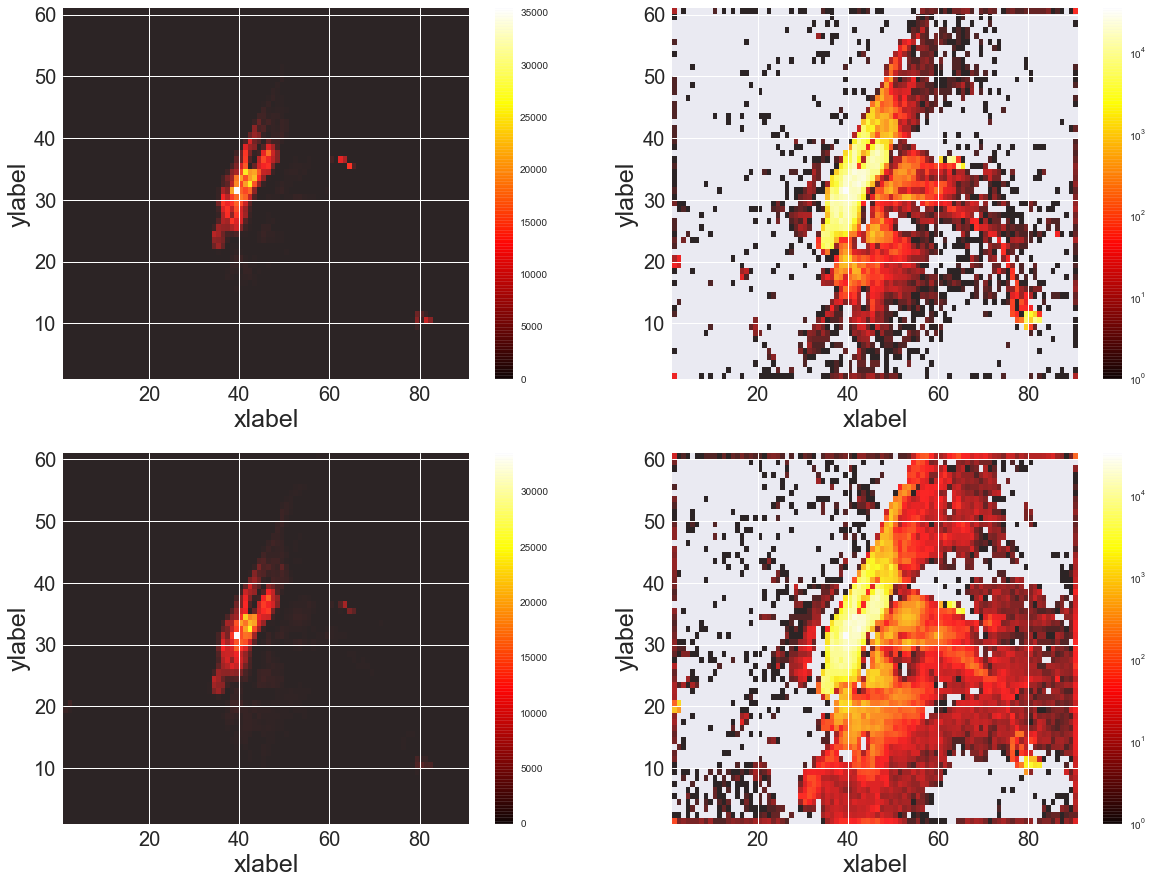

In [16]:
fig = plt.figure(figsize=(20,15))
fig.add_subplot(2,2,1)
pick_xy = trip_label_map(df['pick_xlabel'].values, df['pick_ylabel'].values, bins=[len(xbins)-1, len(ybins)-1])
fig.add_subplot(2,2,2)
trip_label_map(df['pick_xlabel'].values, df['pick_ylabel'].values, bins=[len(xbins)-1, len(ybins)-1], norm=LogNorm(), debug=False)
fig.add_subplot(2,2,3)
drop_xy = trip_label_map(df['drop_xlabel'].values, df['drop_ylabel'].values, bins=[len(xbins)-1, len(ybins)-1])
fig.add_subplot(2,2,4)
trip_label_map(df['drop_xlabel'].values, df['drop_ylabel'].values, bins=[len(xbins)-1, len(ybins)-1], norm=LogNorm(), debug=False)
plt.show()

In [17]:
pick_xy['pixel'] = pick_xy['x'] * 100 + pick_xy['y']
drop_xy['pixel'] = drop_xy['x'] * 100 + drop_xy['y']
df['pick_pixel'] = df['pick_xlabel'] * 100 + df['pick_ylabel']
df['drop_pixel'] = df['drop_xlabel'] * 100 + df['drop_ylabel']
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_day,pickup_time,...,dropoff_weekday,dropoff_timestamp,store_and_fwd_flag,distance,pick_xlabel,pick_ylabel,drop_xlabel,drop_ylabel,pick_pixel,drop_pixel
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,3,14,17.415278,...,1,1457947950,0,1.498521,41,35,44,34,4135,4434
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,6,12,0.726389,...,7,1465664078,0,1.805507,41,29,37,27,4129,3727
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,19,11.590000,...,2,1453176648,0,6.385098,41,34,36,23,4134,3623
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,4,6,19.541944,...,3,1459942780,0,1.485498,35,25,35,23,3525,3523
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,3,26,13.515278,...,6,1458970690,0,1.188588,42,40,42,38,4240,4238


In [18]:
pick_xy.head()

,trips,x,y,pixel
0,36,1,1,101
1,0,1,2,102
2,0,1,3,103
3,0,1,4,104
4,1,1,5,105


### 3.3. Caculate density [ trips/km^2 ]

#### 3.3.1. Extract density tabels

In [19]:
def get_density( x, y, trips, x_dist, y_dist ):
    area = x_dist[int(x)-1]*y_dist[int(y)-1]
    return trips/area

def get_density_df( row, x_dist, y_dist ):
    return get_density( row[1], row[2], row[0], x_dist, y_dist )    

In [20]:
pick_xy['pickup_density'] = pick_xy.apply( get_density_df, axis=1, args=(x_dist, y_dist) )
print pick_xy.head()
print 'Highest density zone: ' 
print pick_xy[ pick_xy.pickup_density == pick_xy.pickup_density.max()]

   trips  x  y  pixel  pickup_density
0     36  1  1    101        0.000007
1      0  1  2    102        0.000000
2      0  1  3    103        0.000000
3      0  1  4    104        0.000000
4      1  1  5    105        0.000338
Highest density zone: 
      trips   x   y  pixel  pickup_density
2310  35419  39  31   3931   114584.623314


In [21]:
drop_xy['dropoff_density'] = drop_xy.apply( get_density_df, axis=1, args=(x_dist, y_dist) )
print drop_xy.head()
print 'Highest density zone: ' 
print drop_xy[ drop_xy.dropoff_density == drop_xy.dropoff_density.max()]

   trips  x  y  pixel  dropoff_density
0     90  1  1    101         0.000018
1      1  1  2    102         0.000338
2      0  1  3    103         0.000000
3      0  1  4    104         0.000000
4      1  1  5    105         0.000338
Highest density zone: 
      trips   x   y  pixel  dropoff_density
2310  33481  39  31   3931    108314.965786


#### 3.3.2. Standardization density

In [22]:
import sklearn.preprocessing as preproc
std_pick = preproc.StandardScaler()
std_drop = preproc.StandardScaler()

In [23]:
pick_xy['pickup_density_std'] = pd.DataFrame(data=std_pick.fit_transform(pick_xy[['pickup_density']].values))
print 'Pickup density std. mean: %.2f, 1_sigma: %.2f'%( std_pick.mean_, np.sqrt(std_pick.var_) )
pick_xy.head()

Pickup density std. mean: 873.52, 1_sigma: 5892.88


,trips,x,y,pixel,pickup_density,pickup_density_std
0,36,1,1,101,0.000007,-0.148233
1,0,1,2,102,0.000000,-0.148233
2,0,1,3,103,0.000000,-0.148233
3,0,1,4,104,0.000000,-0.148233
4,1,1,5,105,0.000338,-0.148233


In [24]:
drop_xy['dropoff_density_std'] = pd.DataFrame(data=std_drop.fit_transform(drop_xy[['dropoff_density']].values))
print 'Dropoff density std. mean: %.2f, 1_sigma: %.2f'%( std_drop.mean_, np.sqrt(std_drop.var_) )
drop_xy.head()

Dropoff density std. mean: 870.86, 1_sigma: 5263.72


,trips,x,y,pixel,dropoff_density,dropoff_density_std
0,90,1,1,101,0.000018,-0.165445
1,1,1,2,102,0.000338,-0.165445
2,0,1,3,103,0.000000,-0.165445
3,0,1,4,104,0.000000,-0.165445
4,1,1,5,105,0.000338,-0.165445


#### 3.3.2. Visualize density tables

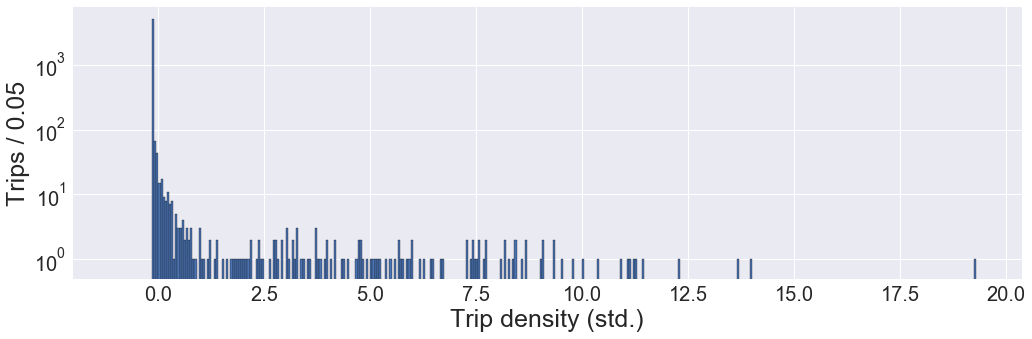

In [25]:
fig = plt.figure(figsize=(17,5))
make_hist(pick_xy['pickup_density_std'].values, xmin=-1, binw=0.05, xlabel='Trip density (std.)', ylabel='Trips', log=True)
plt.show()

In [26]:
pick_DM     = pick_xy['pickup_density'].values.reshape(90,60)
pick_DM_std = pick_xy['pickup_density_std'].values.reshape(90,60)
drop_DM     = drop_xy['dropoff_density'].values.reshape(90,60)
drop_DM_std = drop_xy['dropoff_density_std'].values.reshape(90,60)

In [27]:
def get_imshow( z_2dM, xbins=xbins, ybins=ybins, title='', cmap='hot', alpha=0.85, **kwds  ):
    image = plt.imshow( z_2dM.T, origin='low', extent=[ 1, len(xbins), 1, len(ybins)], cmap=cmap, alpha=alpha, aspect='auto', **kwds)
    plt.colorbar(image)
    plt.tick_params(labelsize=20)
    plt.title(title, fontsize=25)
    plt.xlabel('xlabel', fontsize=25)
    plt.ylabel('ylabel', fontsize=25)

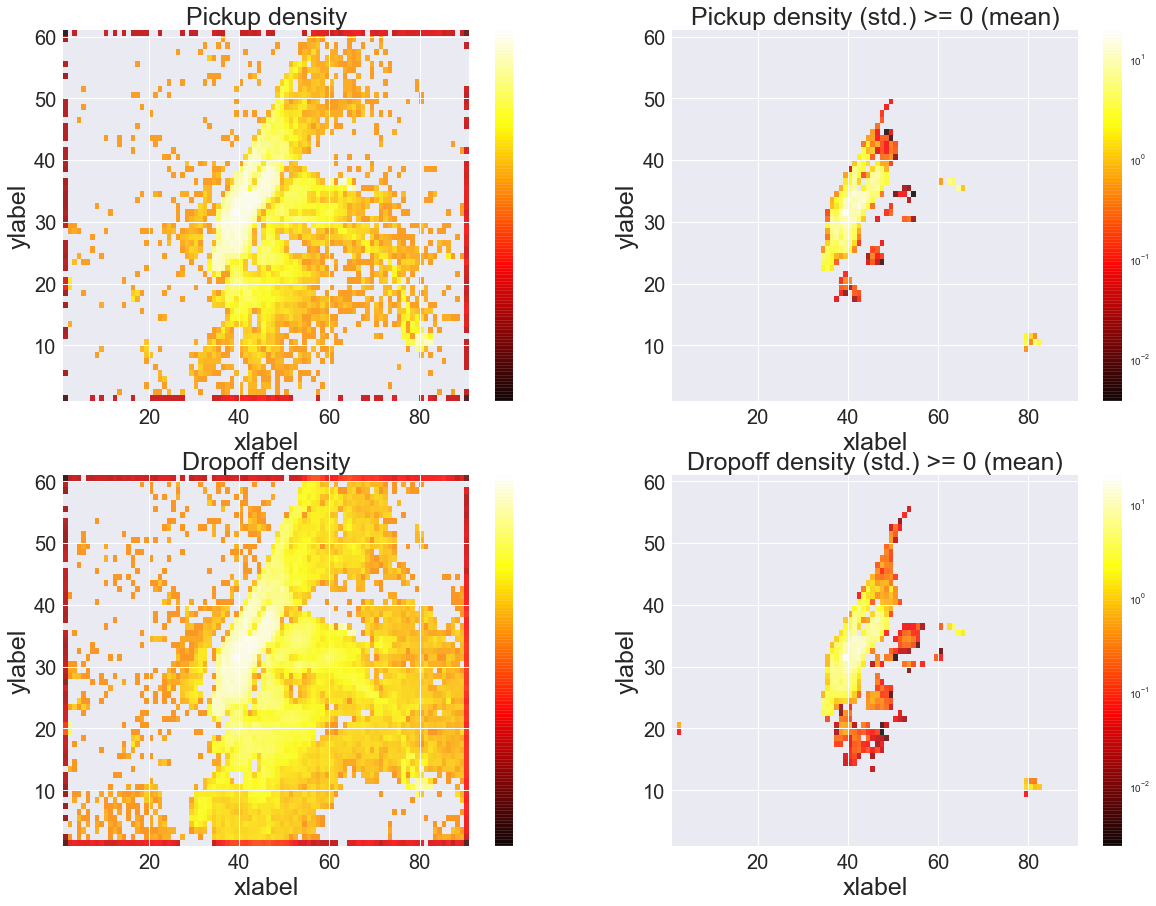

In [28]:
fig = plt.figure(figsize=(20,15))
fig.add_subplot(2,2,1)
get_imshow( pick_DM, title='Pickup density', norm=LogNorm())
fig.add_subplot(2,2,2)
get_imshow( pick_DM_std, title='Pickup density (std.) >= 0 (mean)', norm=LogNorm())
fig.add_subplot(2,2,3)
get_imshow( drop_DM, title='Dropoff density', norm=LogNorm())
fig.add_subplot(2,2,4)
get_imshow( drop_DM_std, title='Dropoff density (std.) >= 0 (mean)', norm=LogNorm())
plt.show()

#### 3.3.3. Label density pixels to origin data

In [29]:
#df = pd.read_csv('../data/train_mini.scv')

In [30]:
def map_px_value( x, df_ref, exract_varName ):
    return df_ref[ (df_ref.pixel == x) ][exract_varName].values[0] 

In [31]:
#start_time = time.time()
#df['pick_D'] = df['pick_pixel'].apply( map_px_value, args=(pick_xy, 'pickup_density'))
#df['pick_Dstd'] = df['pick_pixel'].apply( map_px_value, args=(pick_xy, 'pickup_density_std'))
#print 'Used %.2f sec.'%( time.time() - start_time)

In [32]:
#start_time = time.time()
#df['drop_D'] = df['drop_pixel'].apply( map_px_value, args=(drop_xy, 'dropoff_density'))
#df['drop_Dstd'] = df['drop_pixel'].apply( map_px_value, args=(drop_xy, 'dropoff_density_std'))
#print 'Used %.2f sec.'%( time.time() - start_time)

In [33]:
#df.to_csv('../data/train_density.csv', index=False)
#df.head()

### 3.4. Result plots 

In [248]:
df = pd.read_csv('../data/train_density.csv')
df.head(2)

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_day,pickup_time,...,pick_xlabel,pick_ylabel,drop_xlabel,drop_ylabel,pick_pixel,drop_pixel,pick_D,pick_Dstd,drop_D,drop_Dstd
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,3,14,17.415278,...,41,35,44,34,4135,4434,51936.574796,8.665212,37989.983669,7.051886
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,6,12,0.726389,...,41,29,37,27,4129,3727,31409.754870,5.181886,32415.876383,5.992918


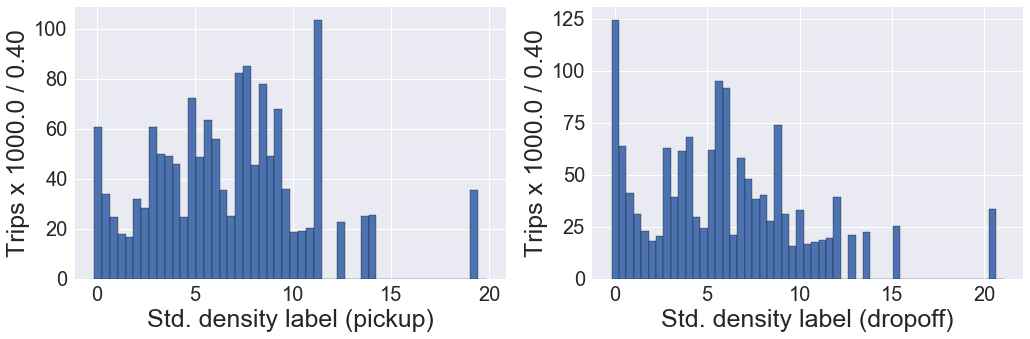

In [249]:
fig = plt.figure(figsize=(17,5))
fig.add_subplot(1,2,1)
make_hist(df['pick_Dstd'].values, binw=0.4, xlabel='Std. density label (pickup)', ylabel='Trips', scale=0.001)
fig.add_subplot(1,2,2)
make_hist(df['drop_Dstd'].values, binw=0.4, xlabel='Std. density label (dropoff)', ylabel='Trips', scale=0.001)
plt.show()

High -> low density: 56.19%
Low -> high density: 43.81%
No changes: 0.000000%


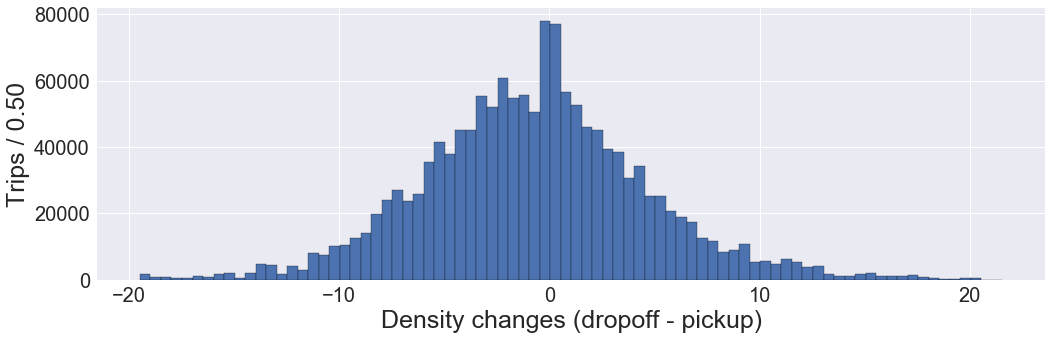

In [250]:
df['dDstd'] = df['drop_Dstd'] - df['pick_Dstd']
print 'High -> low density: %.2f%s'%( float(len(df.dDstd[ df.dDstd < 0. ]))/float(len(df.dDstd))*100 ,'%')
print 'Low -> high density: %.2f%s'%( float(len(df.dDstd[ df.dDstd > 0. ]))/float(len(df.dDstd))*100 ,'%')
print 'No changes: %f%s'%( float(len(df.dDstd[ df.dDstd == 0. ]))/float(len(df.dDstd))*100 ,'%')

fig = plt.figure(figsize=(17,5))
make_hist(df['dDstd'].values, binw=0.5, xlabel='Density changes (dropoff - pickup)', ylabel='Trips')
plt.show()

In [251]:
def make_scatter( x, y, title='', xlabel='', ylabel='', size=100, color='b', marker='.', **kwds):
    s = plt.scatter( x=x, y=y, s=size, c=color, marker=marker, **kwds )
    plt.tick_params(labelsize=18)
    plt.title(title, fontsize=18 )
    plt.xlabel(xlabel, fontsize=18)
    plt.ylabel(ylabel,  fontsize=18)
    return s 

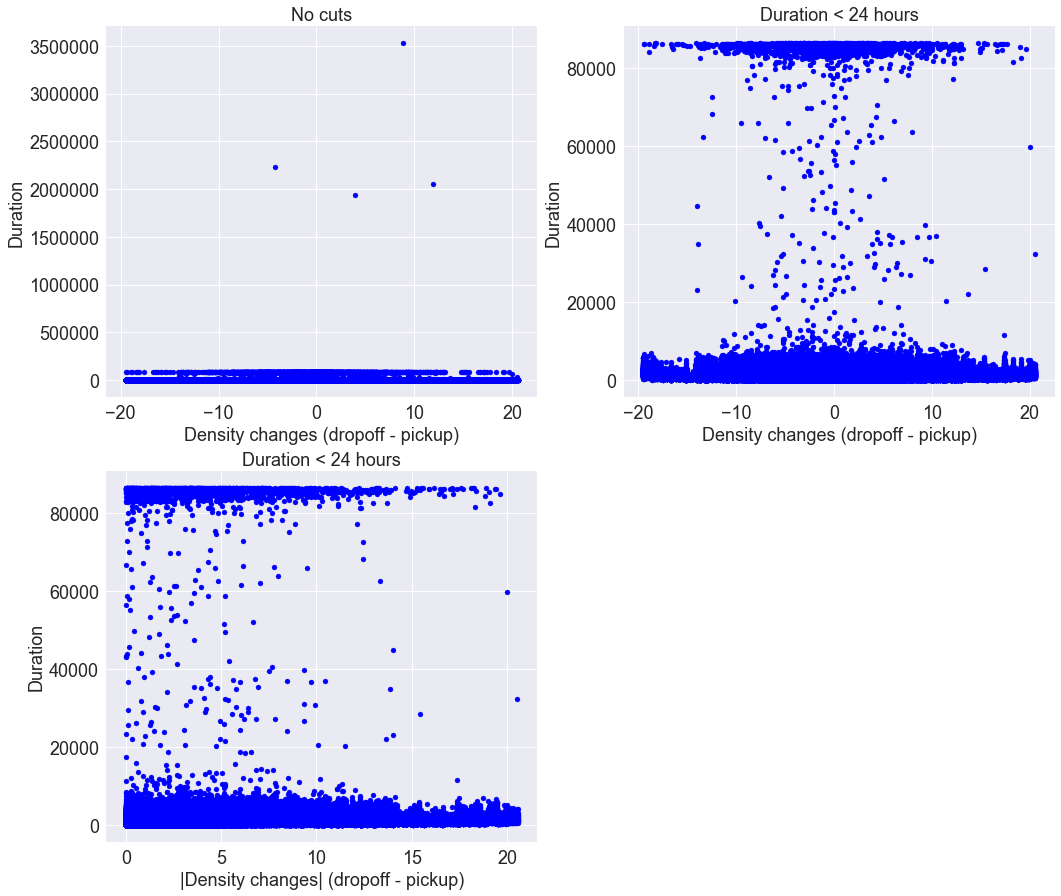

In [252]:
cut= 60*60*24
df['dDstd_abs'] = df['dDstd'].abs()
x_abs = df['dDstd_abs']
x = df['dDstd']
y = df['trip_duration']

fig = plt.figure(figsize=(17,15))
fig.add_subplot(2,2,1)
make_scatter(x.values, y.values, title='No cuts', xlabel='Density changes (dropoff - pickup)', ylabel='Duration')
fig.add_subplot(2,2,2)
make_scatter(x[y < cut].values, y[y < cut].values, title='Duration < %d hours'%( cut/60/60), xlabel='Density changes (dropoff - pickup)', ylabel='Duration')
fig.add_subplot(2,2,3)
make_scatter(x_abs[y < cut].values, y[y < cut].values, title='Duration < %d hours'%(cut/60/60), xlabel='|Density changes| (dropoff - pickup)', ylabel='Duration')
plt.show()

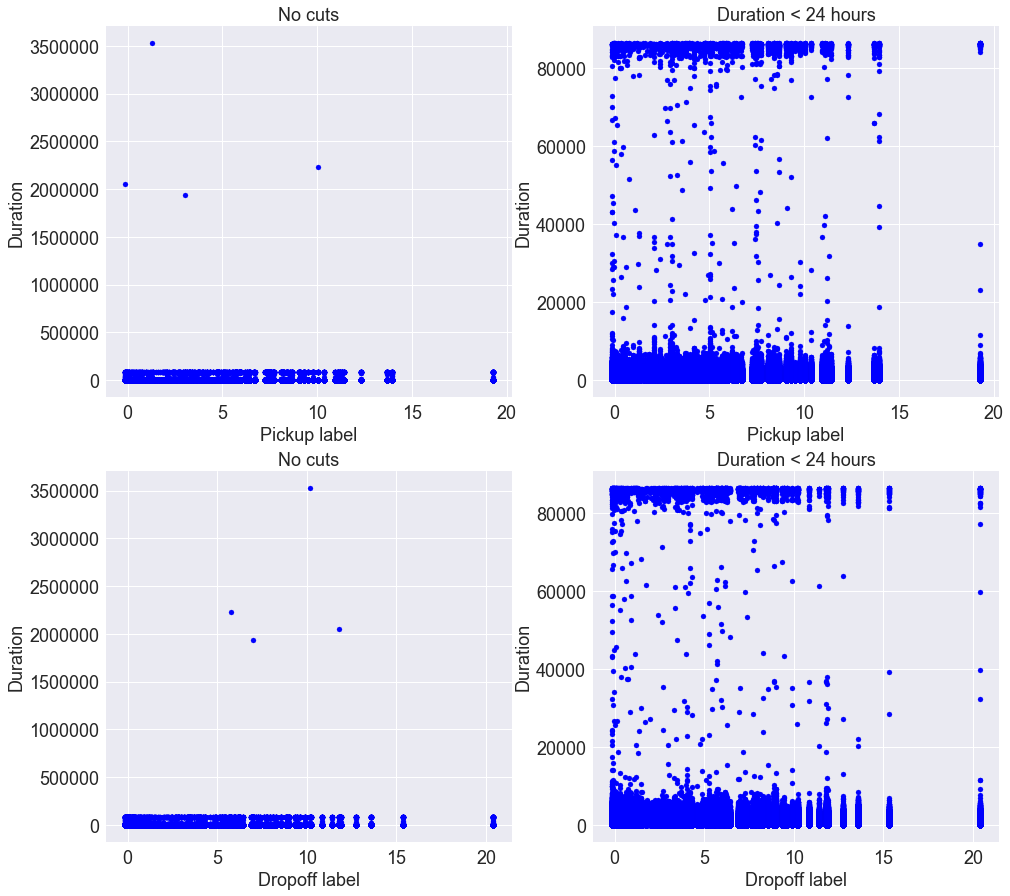

In [253]:
x_pick = df['pick_Dstd']
x_drop = df['drop_Dstd']
fig = plt.figure(figsize=(16,15))
fig.add_subplot(2,2,1)
make_scatter(x_pick.values, y.values, title='No cuts', xlabel='Pickup label', ylabel='Duration')
fig.add_subplot(2,2,2)
make_scatter(x_pick[ y < cut].values, y[ y < cut].values, title='Duration < %d hours'%(cut/60/60), xlabel='Pickup label', ylabel='Duration')
fig.add_subplot(2,2,3)
make_scatter(x_drop.values, y.values, title='No cuts', xlabel='Dropoff label', ylabel='Duration')
fig.add_subplot(2,2,4)
make_scatter(x_drop[ y < cut].values, y[ y < cut].values, title='Duration < %d hours'%( cut/60/60), xlabel='Dropoff label', ylabel='Duration')
plt.show()

In [254]:
def make_mean_plot( df, bins, scale=1./60., ymin=None, groupName='dDstd', getMeanName='trip_duration', xlabel='Density changes', ylabel='Mean of duration', dawErr=False ):
    x = bins[:-1]
    y = df.groupby(pd.cut(df[groupName], bins)).mean()[getMeanName].values*scale
    err = np.sqrt(df.groupby(pd.cut(df[groupName], bins)).var()[getMeanName].values)*scale
    plt.plot(x, y, c='black')
    if dawErr:
        plt.fill_between(x, y-err, y+err, alpha=0.6)
    plt.tick_params(labelsize=20)
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)
    if ymin != None:
        plt.ylim(ymin=ymin)

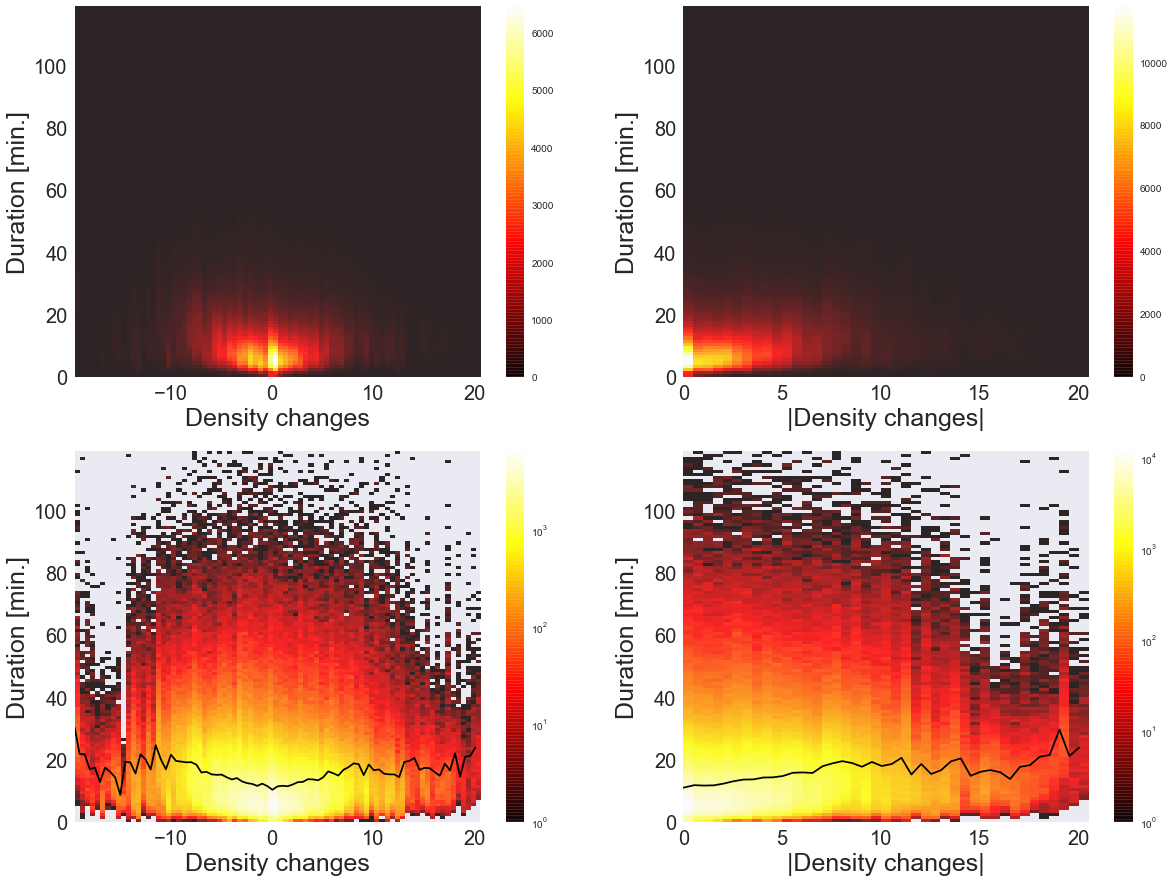

In [255]:
cut= 60*60*2
fig = plt.figure(figsize=(20,15))
fig.add_subplot(2,2,1)
df_T_dD = make_hist2d( x[y<cut].values, y[y<cut].values/60, ylabel='Duration [min.]', xlabel='Density changes', xbinw=0.5)
fig.add_subplot(2,2,2)
df_T_absdD = make_hist2d( x_abs[y<cut].values, y[y<cut].values/60, ylabel='Duration [min.]', xlabel='|Density changes|', xbinw=0.5)

D_bins = np.append(np.unique(df_T_dD.x1.values), df_T_dD.x2.values[-1])

fig.add_subplot(2,2,3)
make_hist2d( x[y<cut].values, y[y<cut].values/60, xbinw=0.5, norm=LogNorm())
make_mean_plot( df[(y < cut)], groupName='dDstd', bins=D_bins, ylabel='Duration [min.]', xlabel='Density changes')
fig.add_subplot(2,2,4)
df_T_absdD = make_hist2d( x_abs[y<cut].values, y[y<cut].values/60, xbinw=0.5, norm=LogNorm())
make_mean_plot( df[(y < cut)], groupName='dDstd_abs', bins=D_bins,  xlabel='|Density changes|', ylabel='Duration [min.]')
plt.show()   

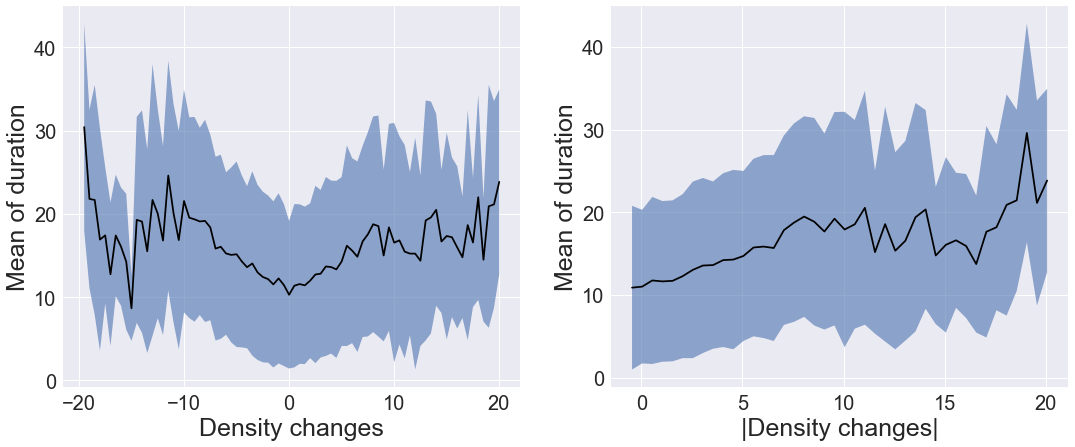

In [256]:
fig = plt.figure(figsize=(18,7)) 
fig.add_subplot(1,2,1)
make_mean_plot( df[(y < cut)], groupName='dDstd', bins=D_bins, dawErr=True)
fig.add_subplot(1,2,2)
make_mean_plot( df[(y < cut)], groupName='dDstd_abs', bins=D_bins, dawErr=True, xlabel='|Density changes|' )
plt.show()

In [257]:
#df[(y < cut)].groupby(pd.cut(df[(y < cut)]['dDstd'], D_bins)).count()
#df_T_dD.groupby('x1').sum()
df.to_csv('../data/train_eda_density.csv', index=False)

---
# 4. About speed

## 4.1. Average speed of locations
### 4.1.1. Get speed of each trip

In [324]:
df = pd.read_csv('../data/train_eda_density.csv')
df['speed'] = df['distance']/(df['trip_duration']/60/60)
df[['distance', 'trip_duration', 'speed']].head()

,distance,trip_duration,speed
0,1.498521,455,11.856428
1,1.805507,663,9.803659
2,6.385098,2124,10.822201
3,1.485498,429,12.465721
4,1.188588,435,9.836594


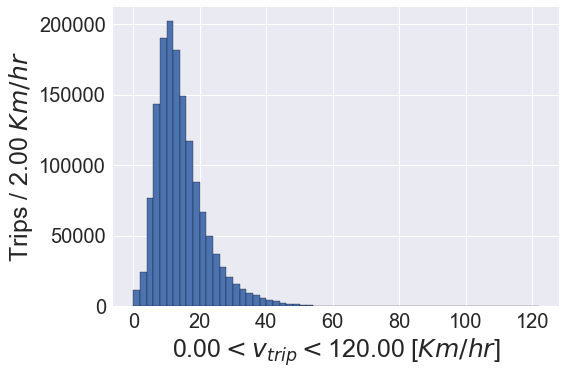

In [325]:
df_v  = df['speed']
#v_max = df_v.quantile(0.995) # 0.5%
#v_min = df_v.quantile(0.005) # 0.5%
v_max = 120. 
v_min = 0. 
make_hist(df_v[(df_v < v_max) & (df_v > v_min)], binw=2, xlabel='%.2f$<v_{trip}<$%.2f'%(v_min, v_max), ylabel='Trips', xunit='$Km/hr$', log=False)
plt.show()

### 4.1.2. Get averge speed of region

In [326]:
df_cut = df[(df_v < v_max) & (df_v > v_min)]

In [347]:
np.zeros((90,60)) 

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [432]:
df_avg_v = 1
df_avg_v = pick_xy['pixel'].to_frame('index')
df_avg_v['pixel'] = pick_xy['pixel']
df_avg_v = df_avg_v.set_index('index')

In [435]:
def fill_Vavg_tabel( df, indexs, name, df_values ):
    df.loc[indexs, name] = df_values

In [450]:
idx_pick = df_cut.groupby(['pick_pixel']).mean().index
idx_drop = df_cut.groupby(['drop_pixel']).mean().index
fill_Vavg_tabel( df_avg_v, idx_pick, 'pick_pixel_v',    df_cut.groupby(['pick_pixel']).mean()['speed'] )
fill_Vavg_tabel( df_avg_v, idx_drop, 'drop_pixel_v',    df_cut.groupby(['drop_pixel']).mean()['speed'] )
fill_Vavg_tabel( df_avg_v, idx_pick, 'pick_pixel_verr', df_cut.groupby(['pick_pixel']).var()['speed'].apply(np.sqrt) )
fill_Vavg_tabel( df_avg_v, idx_drop, 'drop_pixel_verr', df_cut.groupby(['drop_pixel']).var()['speed'].apply(np.sqrt) )
fill_Vavg_tabel( df_avg_v, idx_pick, 'pick_trips',      df_cut.groupby(['pick_pixel']).count()['speed'] )
fill_Vavg_tabel( df_avg_v, idx_drop, 'drop_trips',      df_cut.groupby(['drop_pixel']).count()['speed'] )
df_avg_v['x'] = (df_avg_v['pixel']/100).astype(int)
df_avg_v['y'] = (df_avg_v['pixel']%100).astype(int)
df_avg_v = df_avg_v.fillna(value=0)
#df_avg_v['pick_pixel_v']    = pd.DataFrame( df_cut.groupby(['pick_pixel']).mean()['speed'].values )
#df_avg_v['drop_pixel_v']    = pd.DataFrame( df_cut.groupby(['drop_pixel']).mean()['speed'].values )
#df_avg_v['pick_pixel_verr'] = pd.DataFrame( np.sqrt(df_cut.groupby(['pick_pixel']).var()['speed'].values) )
#df_avg_v['drop_pixel_verr'] = pd.DataFrame( np.sqrt(df_cut.groupby(['drop_pixel']).var()['speed'].values) )
#df_avg_v['pixel']         = pd.DataFrame( df_cut.groupby(['pick_pixel']).mean().index.values )
#df_avg_v['x']            = (df_avg_v['pixel']/100).astype(int)
#df_avg_v['y']            = (df_avg_v['pixel']%100).astype(int)
#df_avg_v['pick_trips']   = pd.DataFrame( df_cut.groupby(['pick_pixel']).count()['vendor_id'].values )
#df_avg_v['drop_trips']   = pd.DataFrame( df_cut.groupby(['drop_pixel']).count()['vendor_id'].values )
#df_avg_v.loc[df_cut.groupby(['pick_pixel']).mean().index, 'pick_pixel_v'] = df_cut.groupby(['pick_pixel']).mean()['speed']

In [ ]:
fill_Vavg_tabel( df_avg_v, idx_pick, 'pick_duration',    df_cut.groupby(['pick_pixel']).mean()['trip_duration'] )
fill_Vavg_tabel( df_avg_v, idx_drop, 'drop_duration',    df_cut.groupby(['drop_pixel']).mean()['trip_duration'] )

In [451]:
df_avg_v.head()

,pixel,pick_pixel_v,drop_pixel_v,pick_pixel_verr,drop_pixel_verr,pick_trips,drop_trips,x,y
index,,,,,,,,,
101,101,11.091548,33.739229,22.177037,20.883999,22.0,73.0,1,1
102,102,0.000000,31.382028,0.000000,0.000000,0.0,1.0,1,2
103,103,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1,3
104,104,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1,4
105,105,0.000000,0.000000,0.000000,0.000000,0.0,0.0,1,5


In [448]:
## Cross checks
#l = []
#for i in range(1,91):
#    for j in range(1,61):
#        px = i*100+j
#        k = len(df_cut[ df_cut['drop_pixel'] == px ])
#        l.append(k)
#        if px == 9031: print k
#print l

In [453]:
#df_avg_v[ (df_avg_v['pick_pixel_verr'].isnull()) | (df_avg_v['drop_pixel_verr'].isnull())].head(10)

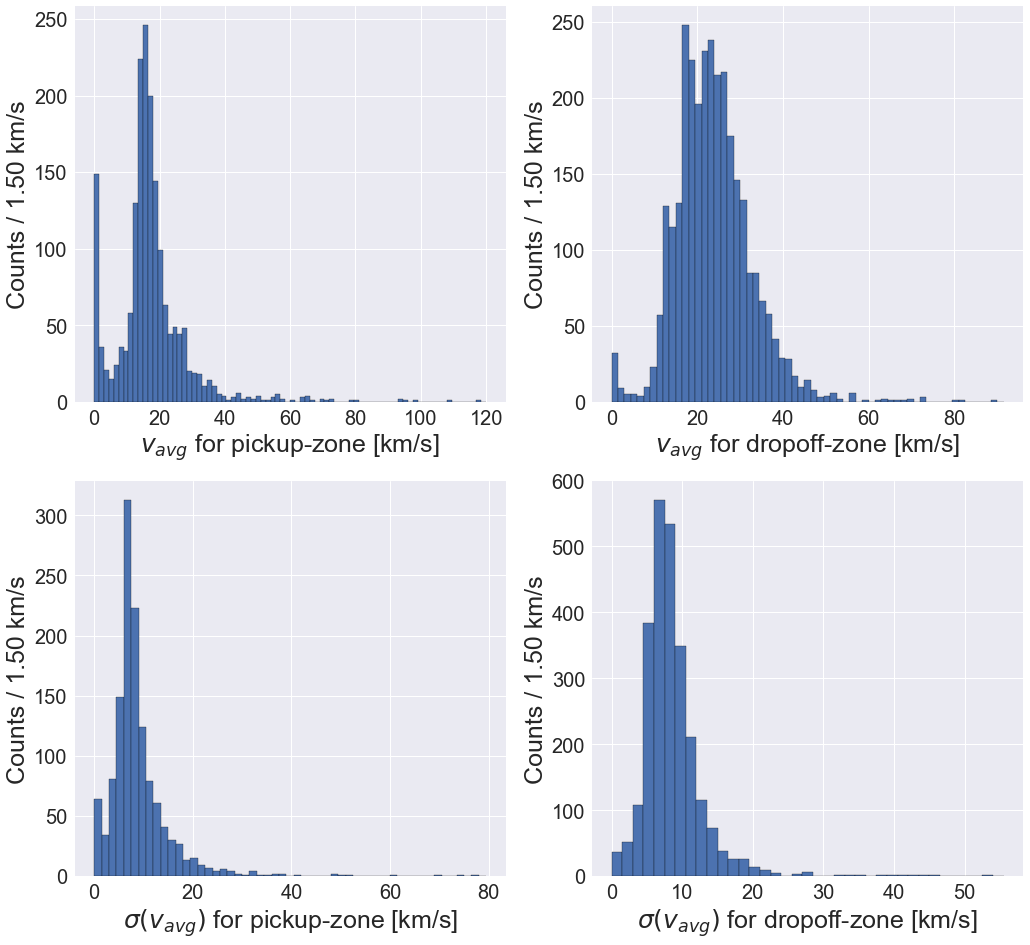

In [456]:
fig = plt.figure(figsize=(17,16))
fig.add_subplot(2,2,1)
make_hist(df_avg_v['pick_pixel_v'],  xmin=0.00001, binw=1.5, xlabel='$v_{avg}$ for pickup-zone', xunit='km/s')
fig.add_subplot(2,2,2)
make_hist(df_avg_v['drop_pixel_v'], xmin=0.00001, binw=1.5, xlabel='$v_{avg}$ for dropoff-zone', xunit='km/s')
fig.add_subplot(2,2,3)
make_hist(df_avg_v['pick_pixel_verr'], xmin=0.00001, binw=1.5, xlabel='$\sigma(v_{avg})$ for pickup-zone', xunit='km/s')
fig.add_subplot(2,2,4)
make_hist(df_avg_v['drop_pixel_verr'], xmin=0.00001, binw=1.5, xlabel='$\sigma(v_{avg})$ for dropoff-zone', xunit='km/s')
plt.show()

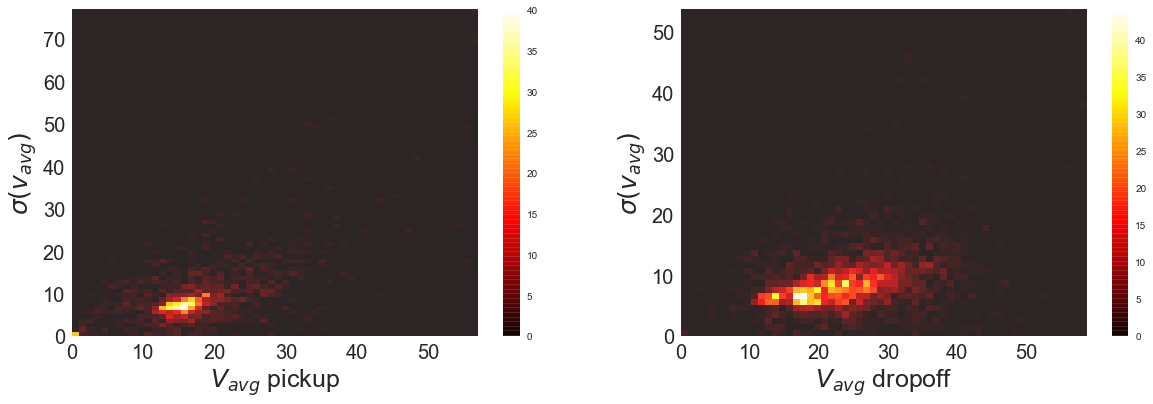

In [463]:
fig = plt.figure(figsize=(20,6))
fig.add_subplot(1,2,1)
make_hist2d( df_avg_v['pick_pixel_v'][ (df_avg_v['pick_pixel_v'] > 0) & (df_avg_v['pick_pixel_v'] < 60) & (df_avg_v['pick_pixel_verr'] > 0) ].values, 
             df_avg_v['pick_pixel_verr'][ (df_avg_v['pick_pixel_v'] > 0) & (df_avg_v['pick_pixel_v'] < 60) & (df_avg_v['pick_pixel_verr'] > 0)  ].values, ylabel='$\sigma(v_{avg})$', xlabel='$V_{avg}$ pickup' )
fig.add_subplot(1,2,2)
make_hist2d( df_avg_v['drop_pixel_v'][ (df_avg_v['drop_pixel_v'] > 0) & (df_avg_v['drop_pixel_v'] < 60) & (df_avg_v['drop_pixel_verr'] > 0) ].values, 
             df_avg_v['drop_pixel_verr'][ (df_avg_v['drop_pixel_v'] > 0) & (df_avg_v['drop_pixel_v'] < 60) & (df_avg_v['drop_pixel_verr'] > 0)  ].values, ylabel='$\sigma(v_{avg})$', xlabel='$V_{avg}$ dropoff'  )
plt.show()

* The error slightly increase as function of $V_{avg}$
* The highest density of $V_{avg}$, 18 km/hr, has about 7-10 km/hr error, i.e. the distance error will be about 360 sec/km.
* Higher $V_{avg}$ has higher uncertainty.

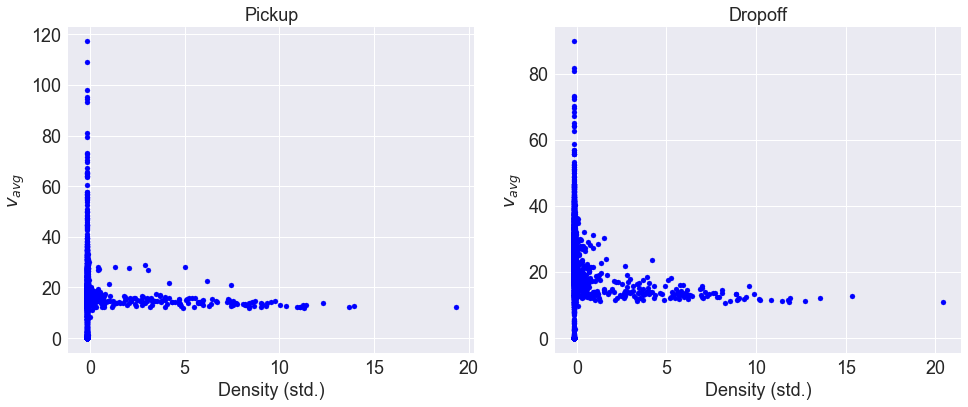

In [464]:
fig = plt.figure(figsize=(16,6))
fig.add_subplot(1,2,1)
make_scatter( pick_xy['pickup_density_std'][ pick_xy['pixel'].isin(df_avg_v['pixel'].values) ].values,
              df_avg_v['pick_pixel_v'].values,  
              title='Pickup',ylabel='$v_{avg}}$', xlabel='Density (std.)')
fig.add_subplot(1,2,2)
make_scatter( drop_xy['dropoff_density_std'][ drop_xy['pixel'].isin(df_avg_v['pixel'].values) ].values,
              df_avg_v['drop_pixel_v'].values, 
              title='Dropoff', ylabel='$v_{avg}}$', xlabel='Density (std.)')
plt.show()

* Higher density region in pickup case has average speed about 18.

In [465]:
def get_hist2d_matrix( X, Y, Z, rangex, rangey ):
    H = np.zeros((len(rangex), len(rangey)))
    iX =np.digitize(X, rangex)-1
    iY =np.digitize(Y, rangey)-1
    
    for i, z in enumerate(Z): 
        H[iX[i]][iY[i]] = z
        
    # Be edges of histogram
    rangex.append( 2*rangex[-1]-rangex[-2] )
    rangey.append( 2*rangey[-1]-rangey[-2] ) 
    
    return H, np.array(rangex), np.array(rangey)

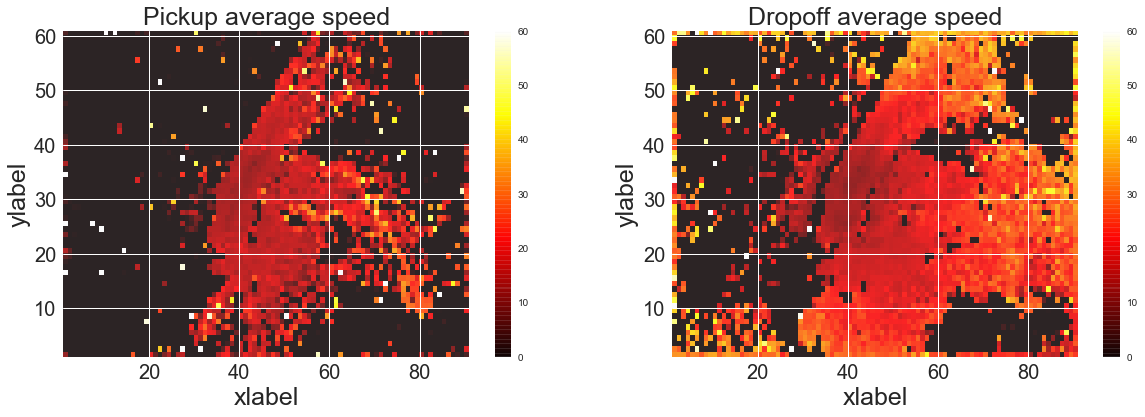

In [466]:
pick_v_2d = get_hist2d_matrix( df_avg_v.x.values, 
                               df_avg_v.y.values, 
                               df_avg_v.pick_pixel_v.values, 
                               range(1,n_xbins+1), 
                               range(1,n_ybins+1))
drop_v_2d = get_hist2d_matrix( df_avg_v.x.values, 
                               df_avg_v.y.values, 
                               df_avg_v.drop_pixel_v.values, 
                               range(1,n_xbins+1), 
                               range(1,n_ybins+1),)

fig = plt.figure(figsize=(20,6))
fig.add_subplot(1,2,1)
get_imshow( pick_v_2d[0], title='Pickup average speed', vmax=60 )
fig.add_subplot(1,2,2)
get_imshow( drop_v_2d[0], title='Dropoff average speed', vmax=60 )
plt.show()

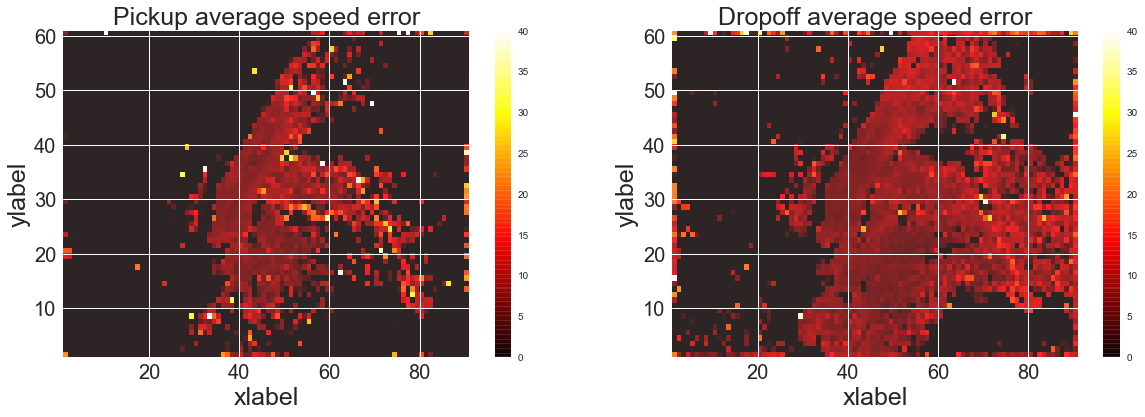

In [469]:
pick_verr_2d = get_hist2d_matrix( df_avg_v.x.values, 
                                  df_avg_v.y.values, 
                                  df_avg_v.pick_pixel_verr.values, 
                                  range(1,n_xbins+1), 
                                  range(1,n_ybins+1))
drop_verr_2d = get_hist2d_matrix( df_avg_v.x.values, 
                                  df_avg_v.y.values, 
                                  df_avg_v.drop_pixel_verr.values, 
                                  range(1,n_xbins+1), 
                                  range(1,n_ybins+1),)

fig = plt.figure(figsize=(20,6))
fig.add_subplot(1,2,1)
get_imshow( pick_verr_2d[0], title='Pickup average speed error', vmax=40 )
fig.add_subplot(1,2,2)
get_imshow( drop_verr_2d[0], title='Dropoff average speed error', vmax=40 )
plt.show()

* Althought, the average speed of pickup location is about 18 km/hr, the higher average speed of pickup location is near by lower trip-density region, i.e. the trips from city center is much slower.  
* The average speed of dropoff location is near the south of city center and Jercey city, i.e. the trips to these place have higher average speed.
* In general, the **pickup average speed** is lower than **dropoff average speed**, since most of pickup location is from city center.

## 4.2. Validation with train data
### 4.2.1. Make new features

In [470]:
df_avg_v_tabel = pd.DataFrame( data=drop_v_2d[0].ravel(), columns=['drop_pixel_v'])
df_avg_v_tabel['pick_pixel_v'] = pd.DataFrame( data=pick_v_2d[0].ravel())
df_avg_v_tabel['drop_pixel_verr'] = pd.DataFrame( data=drop_verr_2d[0].ravel())
df_avg_v_tabel['pick_pixel_verr'] = pd.DataFrame( data=pick_verr_2d[0].ravel())
df_avg_v_tabel['pixel'] = pick_xy['pixel']
df_avg_v_tabel.head()

,drop_pixel_v,pick_pixel_v,drop_pixel_verr,pick_pixel_verr,pixel
0,33.739229,11.091548,20.883999,22.177037,101
1,31.382028,0.000000,0.000000,0.000000,102
2,0.000000,0.000000,0.000000,0.000000,103
3,0.000000,0.000000,0.000000,0.000000,104
4,0.000000,0.000000,0.000000,0.000000,105


In [474]:
start_time = time.time()
df['pick_Vavg'] = df['pick_pixel'].apply( map_px_value, args=(df_avg_v_tabel, 'pick_pixel_v'))
df['drop_Vavg'] = df['drop_pixel'].apply( map_px_value, args=(df_avg_v_tabel, 'drop_pixel_v'))
print 'Used %.2f sec.'%( time.time() - start_time)#

Used 1897.43 sec.


In [475]:
start_time = time.time()
df['pick_Vavg_error'] = df['pick_pixel'].apply( map_px_value, args=(df_avg_v_tabel, 'pick_pixel_verr'))
df['drop_Vavg_error'] = df['drop_pixel'].apply( map_px_value, args=(df_avg_v_tabel, 'drop_pixel_verr'))
print 'Used %.2f sec.'%( time.time() - start_time)

Used 1933.47 sec.


In [476]:
df['drop_pixel'].head()
#df[ (df['pick_Vavg'] == 0) & (df['drop_Vavg'] == 0) ].head() 3

0    4434
1    3727
2    3623
3    3523
4    4238
Name: drop_pixel, dtype: int64

In [482]:
df['dVavg'] = df['drop_Vavg'] - df['pick_Vavg']
df.to_csv('../data/train_eda_density_Vavg3.csv', index=False)

### 4.2.2. Distribution of averge speed from asigned smaples

In [483]:
df = pd.read_csv('../data/train_eda_density_Vavg3.csv')

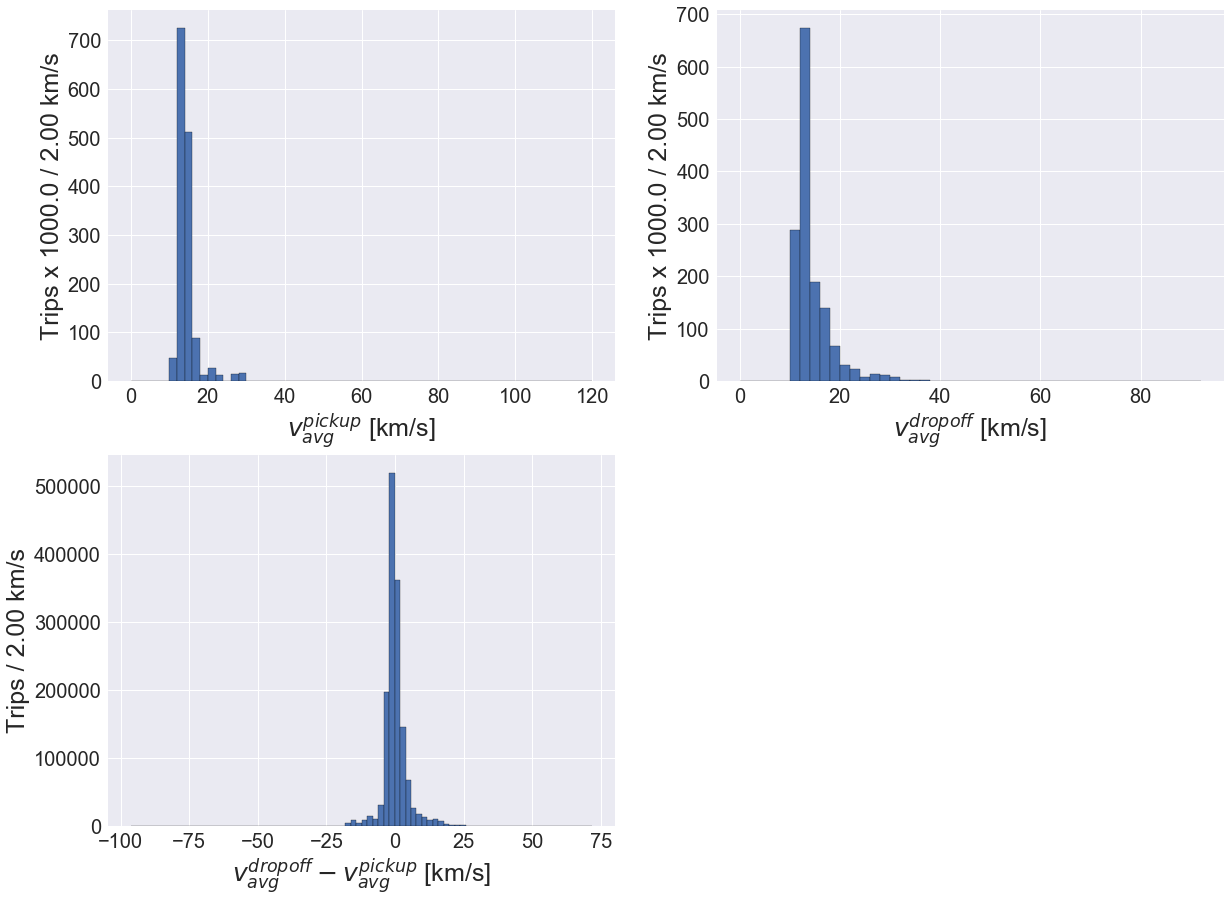

In [491]:
fig = plt.figure(figsize=(20,15))
fig.add_subplot(2,2,1)
make_hist(df['pick_Vavg'].values, binw=2, xlabel='$v_{avg}^{pickup}$', ylabel='Trips', xunit='km/s', scale=0.001)
fig.add_subplot(2,2,2)
make_hist(df['drop_Vavg'].values, binw=2, xlabel='$v_{avg}^{dropoff}$', ylabel='Trips', xunit='km/s', scale=0.001)
fig.add_subplot(2,2,3)
make_hist(df['dVavg'].values, binw=2, xlabel='$v_{avg}^{dropoff}-v_{avg}^{pickup}$', ylabel='Trips', xunit='km/s')
plt.show()

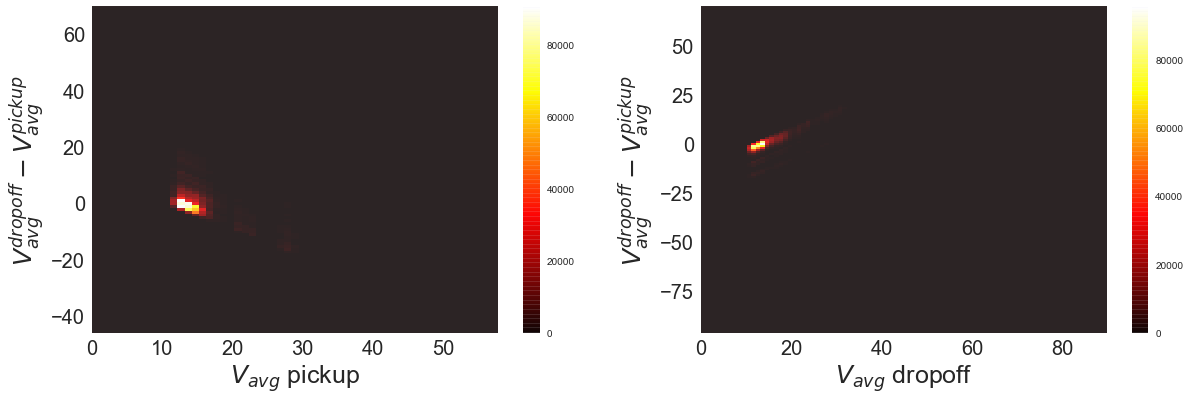

In [485]:
fig = plt.figure(figsize=(20,6))
fig.add_subplot(1,2,1)
make_hist2d( df['pick_Vavg'][ df['pick_Vavg'] < 60 ].values, df['dVavg'][ df['pick_Vavg'] < 60  ].values, ylabel='$V_{avg}^{dropoff}-V_{avg}^{pickup}$', xlabel='$V_{avg}$ pickup' )
fig.add_subplot(1,2,2)
make_hist2d( df['drop_Vavg'].values, df['dVavg'].values, ylabel='$V_{avg}^{dropoff}-V_{avg}^{pickup}$', xlabel='$V_{avg}$ dropoff'  )
plt.show()

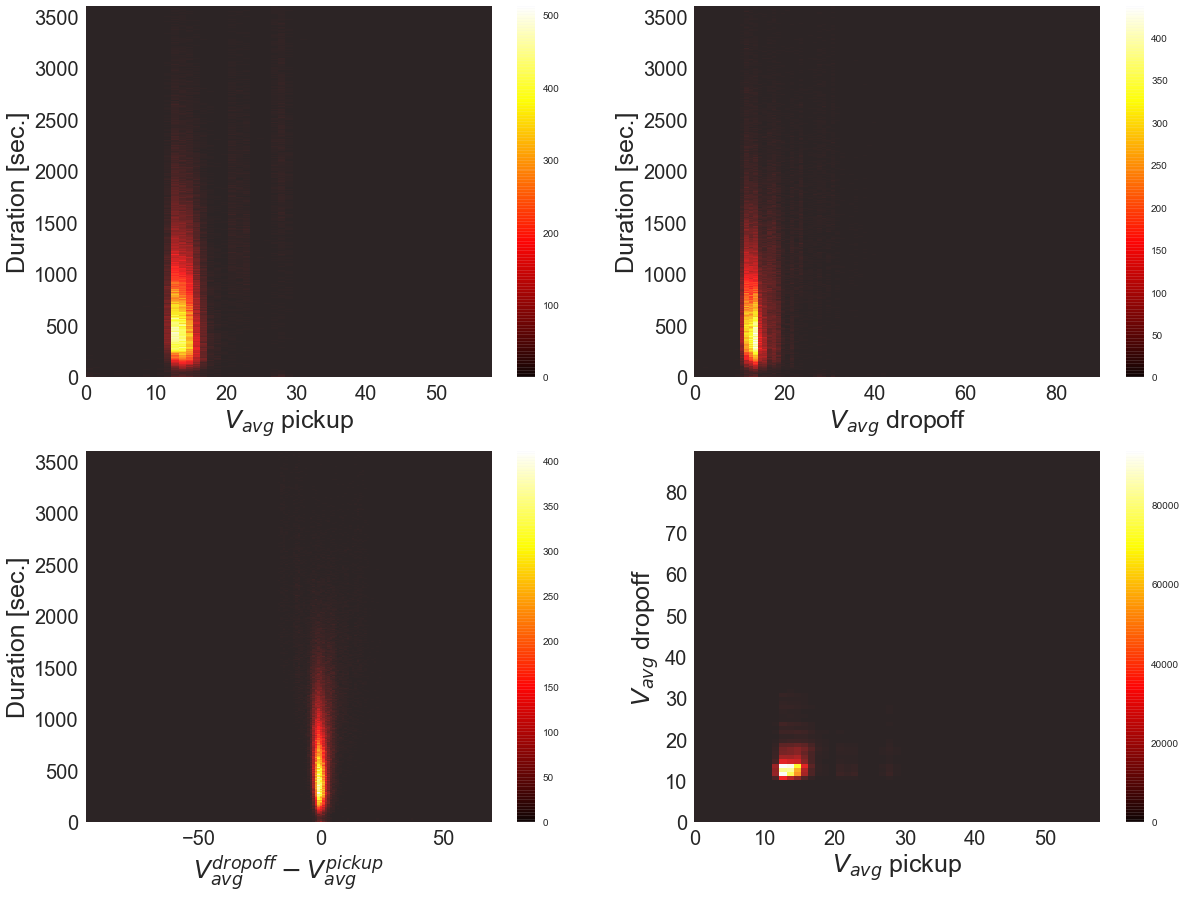

In [486]:
y = df['trip_duration']
cut=60*60*1
fig = plt.figure(figsize=(20,15))
fig.add_subplot(2,2,1)
make_hist2d( df['pick_Vavg'][(df['pick_Vavg'] < 60) & (y < cut)  ].values, y[ (df['pick_Vavg'] < 60) & (y < cut) ].values, ylabel='Duration [sec.]', xlabel='$V_{avg}$ pickup' )
fig.add_subplot(2,2,2)
make_hist2d( df['drop_Vavg'][y < cut].values, y[y < cut].values, ylabel='Duration [sec.]', xlabel='$V_{avg}$ dropoff' )
fig.add_subplot(2,2,3)
make_hist2d( df['dVavg'][y < cut].values, y[y < cut].values, ylabel='Duration [sec.]', xlabel='$V_{avg}^{dropoff}-V_{avg}^{pickup}$' )
fig.add_subplot(2,2,4)
make_hist2d( df['pick_Vavg'][(df['pick_Vavg'] < 60) & (y < cut)  ].values, df['drop_Vavg'][ (df['pick_Vavg'] < 60) & (y < cut) ].values, ylabel='$V_{avg}$ dropoff', xlabel='$V_{avg}$ pickup' )
plt.show()

* $V_{avg}^{dropoff}-V_{avg}^{pickup}$ and $V_{avg}$ dropoff are strongly correlated, but no idea how it goes.
* $V_{avg}$ pickup seems correlated to duration a little bit in high speed region.

### 4.2.3. Distribution of expacted duration

In [508]:
df['expect_duration_pickup']  = df['distance']/df['pick_Vavg']*60*60
df['expect_duration_dropoff'] = df['distance']/df['drop_Vavg']*60*60
df['expect_duration_avg'] = df['distance']/(df['pick_Vavg']+df['drop_Vavg'])*2*60*60

avgerr = (df['pick_Vavg_error']**2+df['drop_Vavg_error']**2).apply(np.sqrt)
df['expect_duration_avg_error'] = df['expect_duration_avg']*avgerr/(df['pick_Vavg']+df['drop_Vavg'])

df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_day,pickup_time,...,speed,pick_Vavg,drop_Vavg,pick_Vavg_error,drop_Vavg_error,dVavg,expect_duration_pickup,expect_duration_dropoff,expect_duration_avg,expect_duration_avg_error
0,2,1,-73.982155,40.767937,-73.964630,40.765602,455,3,14,17.415278,...,11.856428,12.647951,12.186511,6.055981,6.370717,-0.461440,426.525601,442.675916,434.450717,153.767929
1,1,1,-73.980415,40.738564,-73.999481,40.731152,663,6,12,0.726389,...,9.803659,13.895958,12.365101,7.416681,5.280355,-1.530857,467.749384,525.658947,495.016281,171.615497
2,2,1,-73.979027,40.763939,-74.005333,40.710087,2124,1,19,11.590000,...,10.822201,12.220071,16.286034,6.745028,7.882526,4.065962,1881.032760,1411.415136,1612.732042,586.935312
3,2,1,-74.010040,40.719971,-74.012268,40.706718,429,4,6,19.541944,...,12.465721,14.588690,15.032400,6.445864,6.956154,0.443711,366.571259,355.751191,361.080185,115.603875
4,2,1,-73.973053,40.793209,-73.972923,40.782520,435,3,26,13.515278,...,9.836594,15.487073,15.689971,6.578663,6.452190,0.202898,276.289677,272.716786,274.491606,81.128307


In [509]:
df[ df['expect_duration_pickup'] == float('Inf') ]

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_month,pickup_day,pickup_time,...,speed,pick_Vavg,drop_Vavg,pick_Vavg_error,drop_Vavg_error,dVavg,expect_duration_pickup,expect_duration_dropoff,expect_duration_avg,expect_duration_avg_error
13046,1,1,-73.881195,40.882942,-73.965141,40.762486,355,6,27,18.622500,...,153.559078,0.0,12.186511,0.0,6.370717,12.186511,inf,4.473263e+03,8.946527e+03,4676.957218
25397,2,1,-74.069908,40.739052,-74.157913,40.712528,223,3,27,16.478333,...,128.840458,0.0,0.000000,0.0,0.000000,0.000000,inf,inf,inf,NaN
39020,2,1,-74.393555,40.785603,-74.398514,40.781822,16,1,18,18.330556,...,133.307874,0.0,41.146944,0.0,0.000000,41.146944,inf,5.183680e+01,1.036736e+02,0.000000
182695,2,5,-74.191154,40.654186,-74.170135,40.678253,79,5,23,9.049167,...,146.281205,0.0,0.000000,0.0,0.000000,0.000000,inf,inf,inf,NaN
313032,2,1,-73.750664,40.802101,-73.752296,40.803879,6,6,26,16.751389,...,144.445558,0.0,0.000000,0.0,0.000000,0.000000,inf,inf,inf,NaN
595540,1,1,-78.547401,40.817131,-79.786133,40.917637,279,3,20,21.132222,...,1351.741558,0.0,29.866333,0.0,22.531489,29.866333,inf,1.262746e+04,2.525492e+04,19052.587197
652631,2,1,-74.136009,40.734112,-74.138702,40.733994,3,3,31,20.601667,...,272.761428,0.0,0.000000,0.0,0.000000,0.000000,inf,inf,inf,NaN
945772,2,1,-73.819862,40.767376,-73.955666,40.769283,248,1,1,0.688056,...,166.043022,0.0,14.605903,0.0,6.949221,14.605903,inf,2.819317e+03,5.638634e+03,2682.758886
1157625,2,5,-73.897095,40.610332,-73.896828,40.613152,4,6,18,19.594722,...,282.847217,0.0,0.000000,0.0,0.000000,0.000000,inf,inf,inf,NaN


* Due to the cut on 120 km/hr., those zones has 0 average speed, i.e. only one single sample in that pixel. It cause the infinity value in expected duration. 

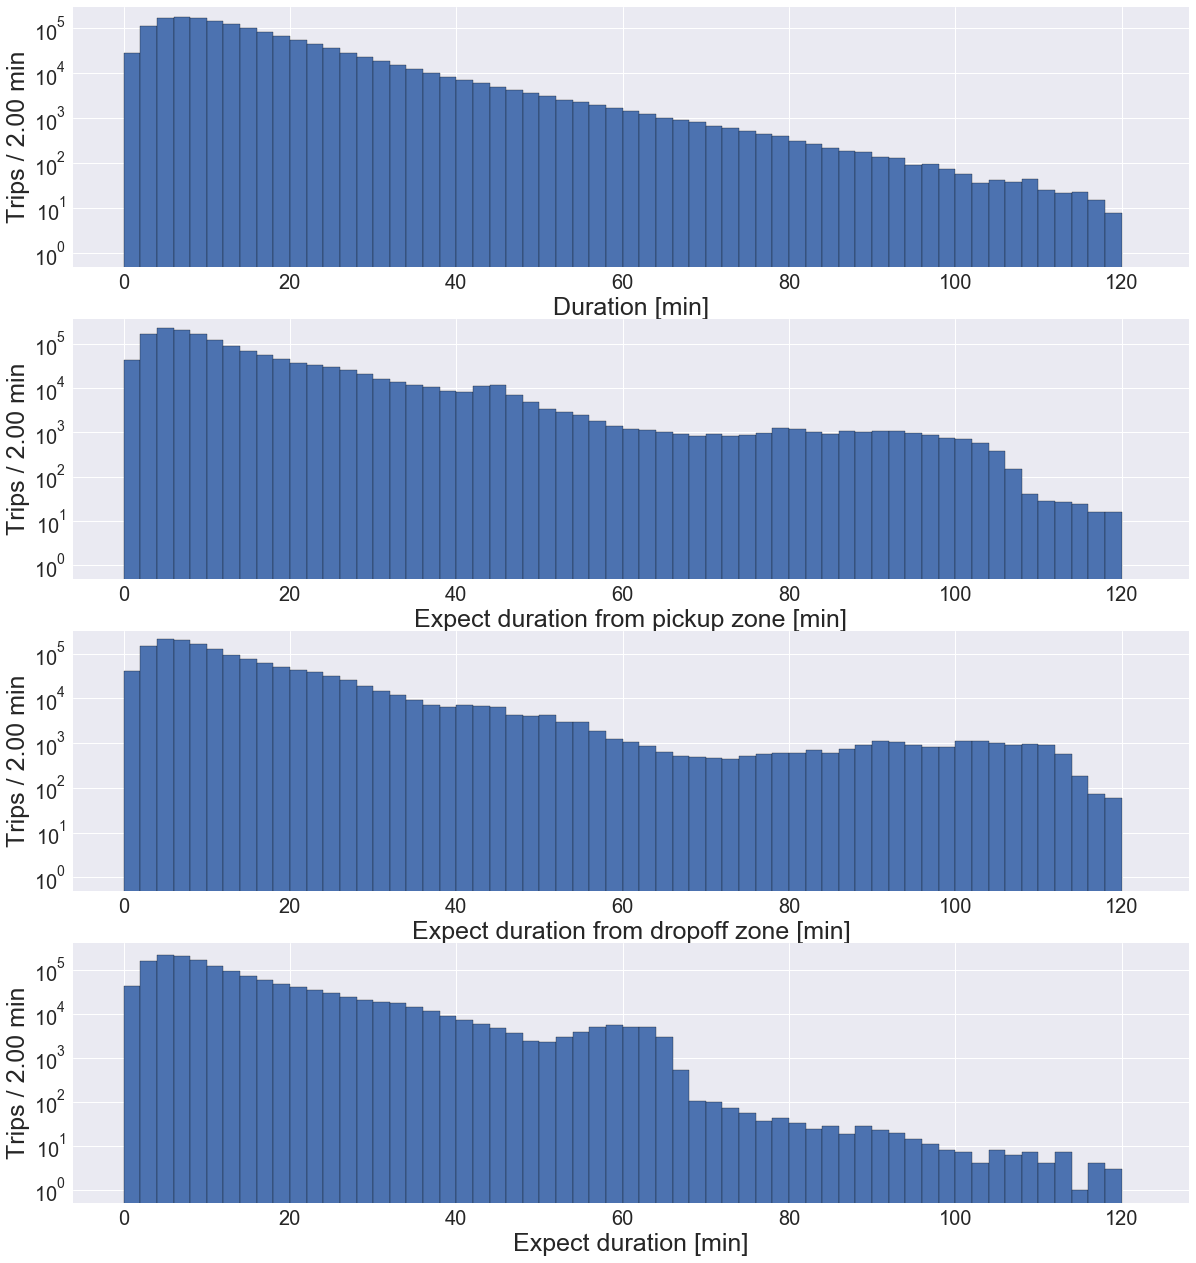

In [510]:
t_cut = 60*2
x_t_   = df['trip_duration']/60
x_tp_  = df['expect_duration_pickup']/60
x_td_  = df['expect_duration_dropoff']/60
x_avg_ = df['expect_duration_avg']/60
x_err_ = df['expect_duration_avg_error']/60 

x_t   =  x_t_[ (x_t_ < t_cut)  & (x_tp_ != float('Inf')) & (x_td_ != float('Inf'))]
x_tp  = x_tp_[ (x_tp_ < t_cut) & (x_tp_ != float('Inf')) & (x_td_ != float('Inf'))]
x_td  = x_td_[ (x_td_ < t_cut) & (x_tp_ != float('Inf')) & (x_td_ != float('Inf'))]
x_avg = x_avg_[ (x_avg_ < t_cut) & (x_tp_ != float('Inf')) & (x_td_ != float('Inf'))]
x_err = x_err_[ (x_avg_ < t_cut) & (x_tp_ != float('Inf')) & (x_td_ != float('Inf'))]

fig = plt.figure(figsize=(20,22))
fig.add_subplot(4,1,1)
make_hist( x_t.values, binw=2, log=True, xlabel='Duration', ylabel='Trips', xunit='min' )
fig.add_subplot(4,1,2)
make_hist( x_tp.values, binw=2, log=True, xlabel='Expect duration from pickup zone', ylabel='Trips', xunit='min'  )
fig.add_subplot(4,1,3)
make_hist( x_td.values, binw=2, log=True, xlabel='Expect duration from dropoff zone', ylabel='Trips', xunit='min'  )
fig.add_subplot(4,1,4)
make_hist( x_avg.values, binw=2, log=True, xlabel='Expect duration', ylabel='Trips', xunit='min'  )
plt.show()

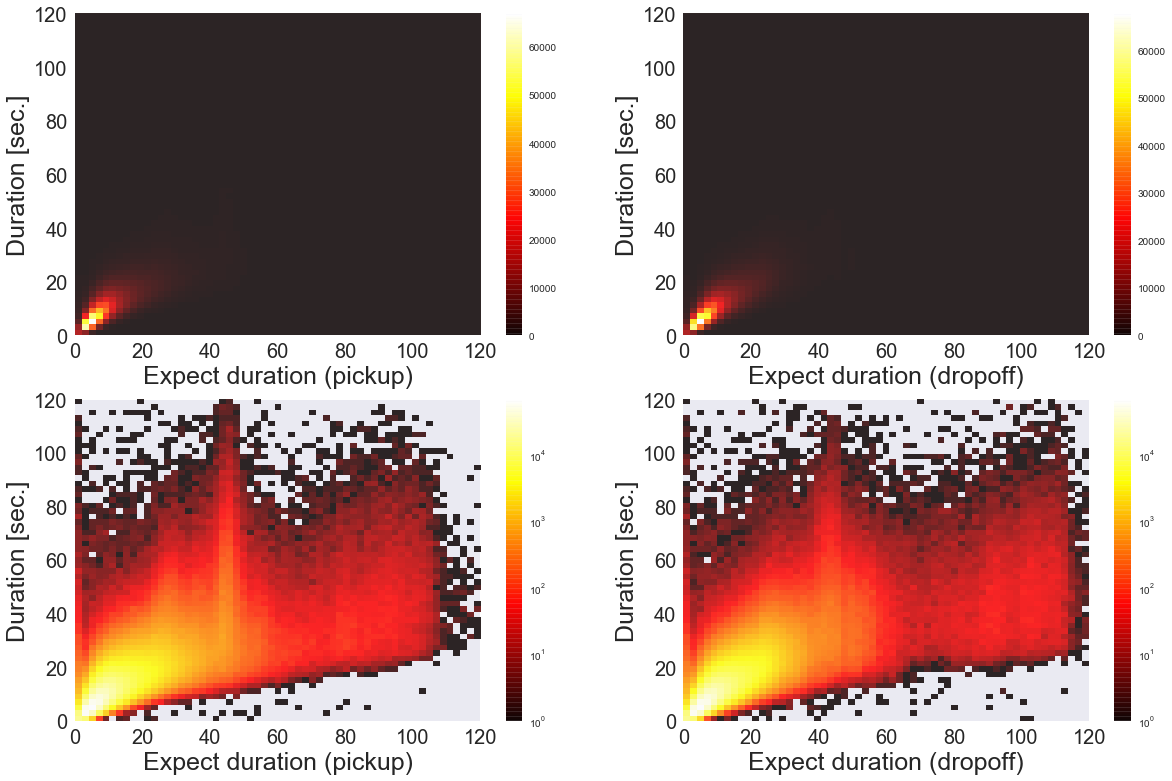

In [504]:
fig = plt.figure(figsize=(20,13))
fig.add_subplot(2,2,1)
make_hist2d( x_tp[ (x_t_ < t_cut) ].values, x_t[ (x_tp_ < t_cut) ].values, xbinw=2, ybinw=2, ylabel='Duration [sec.]', xlabel='Expect duration (pickup)')
fig.add_subplot(2,2,2)
make_hist2d( x_td[ (x_t_ < t_cut) ].values, x_t[ (x_td_ < t_cut) ].values, xbinw=2, ybinw=2, ylabel='Duration [sec.]', xlabel='Expect duration (dropoff)')
fig.add_subplot(2,2,3)
make_hist2d( x_tp[ (x_t_ < t_cut) ].values, x_t[ (x_tp_ < t_cut) ].values, xbinw=2, ybinw=2, ylabel='Duration [sec.]', xlabel='Expect duration (pickup)', norm=LogNorm())
fig.add_subplot(2,2,4)
make_hist2d( x_td[ (x_t_ < t_cut) ].values, x_t[ (x_td_ < t_cut) ].values, xbinw=2, ybinw=2, ylabel='Duration [sec.]', xlabel='Expect duration (dropoff)', norm=LogNorm())
plt.show()

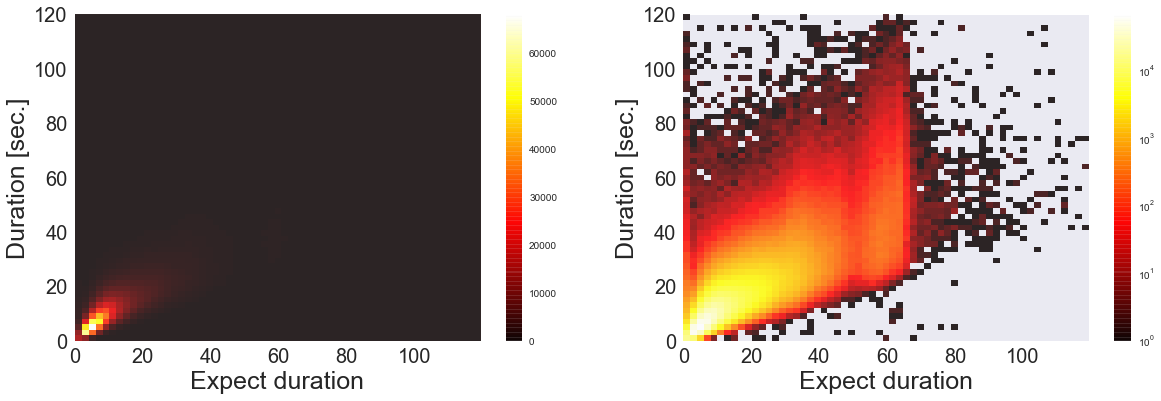

In [505]:
fig = plt.figure(figsize=(20,6))
fig.add_subplot(1,2,1)
make_hist2d( x_avg[ (x_t_ < t_cut) ].values, x_t[ (x_avg_ < t_cut) ].values, xbinw=2, ybinw=2, ylabel='Duration [sec.]', xlabel='Expect duration')
fig.add_subplot(1,2,2)
make_hist2d( x_avg[ (x_t_ < t_cut) ].values, x_t[ (x_avg_ < t_cut) ].values, xbinw=2, ybinw=2, ylabel='Duration [sec.]', xlabel='Expect duration', norm=LogNorm())
plt.show()

* The expect duration from pickup zone is slightly better than from dropoff.
* After the several selection cuts : distance, duration, the expected duration may can perform well.
* This validation is using the origin train data, it's better to test in test data.
* Check diviation of predicted speed $\sqrt{\frac{\sum{(V_i-V_{avg})^2}}{N}}$ is roughly about 10 km/hr, thus the expected duration has about $\pm6$ min diviation from true duration.  

---
## Check speed with density changes

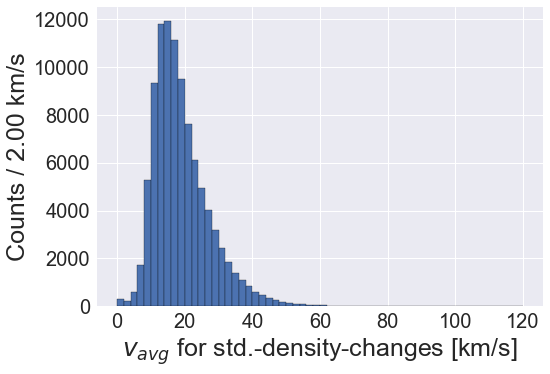

In [492]:
avg_v = df_cut.groupby(['dDstd'])['speed'].mean().values
make_hist(avg_v, binw=2, xlabel='$v_{avg}$ for std.-density-changes', xunit='km/s')
plt.show()

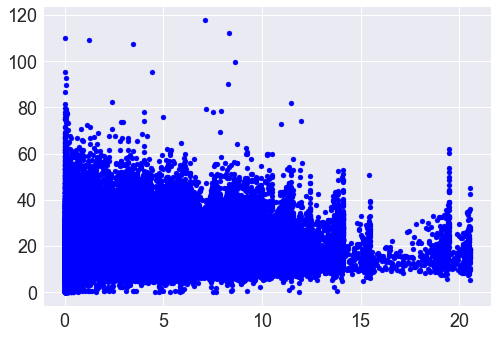

In [493]:
dDens = df_cut.groupby(['dDstd'])['speed'].mean().index.values
np.vstack((avg_v, dDens))
make_scatter( np.abs(dDens), avg_v)
plt.show()

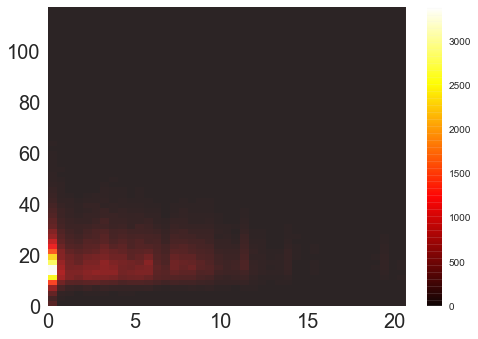

In [494]:
make_hist2d(np.abs(dDens), avg_v, xbinw=0.5, ybinw=2)
plt.show()

---
## 5. Subway
### 5.1.

## Play matplotlib

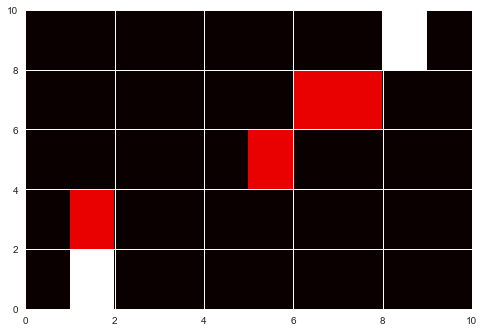

[[ 0.  0.  0.  0.  0.]
 [ 3.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  3.]
 [ 0.  0.  0.  0.  0.]]


In [66]:
counts, xedges, yedges, image = plt.hist2d( x=np.array([1,1,1,1,5,6,7,8,8,8]), 
                                            y=np.array([0,1,1,3,5,6,7,9,9,8]),  
                                            range=[[0, 10], 
                                                   [0, 10]],
                                            bins=[10,5],
                                            cmap='hot')
plt.show()
print counts

In [67]:
data = { 'trips' : counts.ravel().astype(int),
         'x' : np.repeat(xedges[:-1].astype(int), len(yedges)-1),
         'y' : np.tile(yedges[:-1].astype(int), len(xedges)-1),
        }

In [68]:
test = pd.DataFrame(data=data)
test['trips'].values.reshape(10,5)

array([[0, 0, 0, 0, 0],
       [3, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 3],
       [0, 0, 0, 0, 0]])

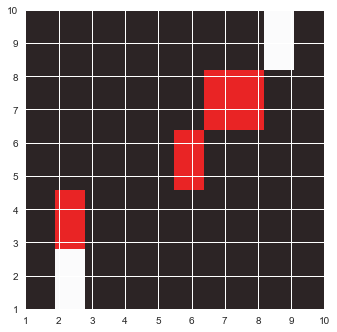

In [69]:
plt.imshow(test['trips'].values.reshape(10,5).T, 
           interpolation='nearest', 
           origin='low', 
           extent=[ 1, 10, 1, 10], 
           cmap='hot',
           alpha=0.85)
plt.show()